## Data Preprocessing & Modelling Pipeline

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
import joblib
from utils.find_root import find_project_root
from tqdm import tqdm
import time
import random
from datetime import datetime

In [67]:
# Check GPU access for LSTM-AE training
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# test if GPU engages
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.matmul(a, a)
print(b)

TensorFlow version: 2.10.1
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(
[[ 7. 10.]
 [15. 22.]], shape=(2, 2), dtype=float32)


In [68]:
# Freeze randomness for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [69]:
# Retrieve the project root dynamically and set it as working directory
project_root = find_project_root()
os.chdir(project_root)

# Define output directories for ML models
MODEL_OUTPUT_DIR = "outputs/modelling/models/"
MODEL_METADATA_DIR = "outputs/modelling/metadata/"
MODEL_PREDICTIONS_DIR = "outputs/modelling/predictions/"
MODEL_INPUT_DIR = "data/processed/model_input/"

# Ensure output directories exist
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_METADATA_DIR, exist_ok=True)
os.makedirs(MODEL_PREDICTIONS_DIR, exist_ok=True)
os.makedirs(MODEL_INPUT_DIR, exist_ok=True)

#### Step 0 - Dataset Loading and Splitting

**Goal**:
Split the historical dataset into training and validation subsets while preserving time order. The training set was used for model fitting and retrospective scoring. The validation set was used for monitoring early stopping during LSTM-AE training and for Isolation Forest threshold evaluation. A separate test set was excluded due to limited duration.

---
**Data Splitting & Anomaly Masking Strategy**

To avoid lookahead bias, we used **time-based splits** where models only learn from past data — a best practice in time-series anomaly detection (Trinh, 2022; Darban, 2024).

For **Isolation Forest**:

- During LSTM-AE training, we applied a **relaxed 3rd percentile threshold** with a cap of **9 anomalies per sequence** to mask noisy timestamps. This helped ensure the LSTM-AE learned from stable input patterns.
- For the **validation set**, a stricter **1st percentile threshold** was combined with the same anomaly cap. As a result, the validation sequences remained more contaminated and better reflected borderline or residual anomalies (Antwarg et al., 2021; Wenig, 2022).

For **retrospective labelling**, we reused the relaxed **3rd percentile** IF threshold but **did not apply anomaly caps**, to reflect how the system would operate in deployment.

This strategy maintains a balance between **clean model training** and **realistic anomaly scoring**, enabling more effective downstream hybrid labelling and interpretability.


In [70]:
# Step 0.1 Load dataset
DATASET_PATH = "data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv"
df = pd.read_csv(DATASET_PATH, parse_dates=['date'], index_col='date')
df = df.asfreq('h')
df.head()

,temperature_2m,surface_pressure,precipitation,wind_speed_10m
date,,,,
2017-02-01 00:00:00,9.6,1008.2,0.0,14.6
2017-02-01 01:00:00,9.6,1007.4,0.0,14.6
2017-02-01 02:00:00,9.9,1006.8,0.6,15.1
2017-02-01 03:00:00,10.0,1006.5,0.3,15.0
2017-02-01 04:00:00,10.2,1006.2,0.3,15.5


In [71]:
# Step 0.2: Define chronological splits
train_start, train_end = "2017-02-01", "2025-01-31"
val_start, val_end = "2025-02-01", "2025-04-30"

# Step 0.3: Subset dataframe
df_train = df.loc[train_start:train_end]
df_val = df.loc[val_start:val_end]

print(f"Training set: {len(df_train)} rows (~{len(df_train)/24:.0f} days; ~{len(df_train)/24/30:.0f} months; ~{len(df_train)/24/30/12:.0f} years).")
print(f"Validation set: {len(df_val)} rows (~{len(df_val)/24:.0f} days; ~{len(df_val)/24/30:.0f} months)).")

Training set: 70128 rows (~2922 days; ~97 months; ~8 years).
Validation set: 2136 rows (~89 days; ~3 months)).


#### Step 1 – Feature Transformation & Normalisation
**Goal**: Convert raw hourly weather data into scale-stable, model-ready inputs using rolling statistics, smoothing, robust scaling, and log transforms. These steps were designed based on EDA insights and tailored to each model’s needs. They were consistently applied across training, validation, and inference phases. The transformation pipeline draws on recent best practices in time-series anomaly detection and climate-focused ML (Tawalkuli, 2024; Trinh, 2022; Darban, 2024; Bakhashwain, 2020).

---
**Isolation Forest Inputs**

- **Temperature & Surface Pressure**
  These variables show smooth seasonal trends and daily cycles. We applied a **60-day rolling z-score**, allowing the model to focus on short-lived fluctuations over long-term drifts (Tawalkuli, 2024; Kulkarni, 2024; Almuqati, 2024).

- **Wind Speed**
  Wind is highly variable. To reduce noise, a **3-hour moving average** was applied, followed by **60-day IQR scaling**, which preserves ramps and gusts while filtering micro-spikes (Tawalkuli, 2024; Yang, 2023; Trinh, 2022).

- **Precipitation**
  Rainfall is sparse and skewed. We applied a **log1p transform** to dampen extreme values (Trinh, 2022; Darban, 2024). Then, **12-hour and 24-hour rolling z-scores** were computed to detect both gradual frontal systems and sudden convective spikes (Bâra, 2024; Mahmood, 2023).

---

**LSTM-AE Inputs**

- **Temperature, Surface Pressure, Wind Speed:**<br>
  These were **robustly scaled per 720-hour sequence** using **median and IQR**, making the LSTM more resilient to outliers during training (Antwarg, 2021; Yang, 2023; Liu, 2020).

- **Precipitation**
  Kept in its **log-transformed** form without further scaling. Its sparsity and episodic nature made standardisation unsuitable (Trinh, 2022; Darban, 2024).

- **Cyclical Features** (engineered later in Step 2) were retained as **sine and cosine pairs** for hour and month to support temporal learning.

---

These pre-processing steps ensure the Isolation Forest receives normalised, scale-aware features and the LSTM-AE learns on stable, context-aware sequences — reducing false positives and improving anomaly sensitivity (Mahmood, 2023; Liu, 2020; Wenig, 2022).


In [72]:
# Step 1.1: Select features (precautionary)
raw_features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precipitation']
df_train = df_train[raw_features].copy()
df_val =df_val[raw_features].copy()

In [73]:
# Step 1.2: Set parameters for normalisation
window_60d = 1440 # rolling window size; 60-day window captures seasonal baselines for IF
min_periods_60d = 720 # minimum number of observations required for rolling calculations
window_12h = 12 # rolling window size for 12-hour rolling z-score; 12h captures local volatility for sparse events like precipitation
window_24h = 24 # rolling window size for 24-hour rolling z-score; 24h isolates larger spikes
min_periods_12h = 6 # minimum number of observations required for rolling calculations for 12-hour rolling z-score
min_periods_24h = 12 # minimum number of observations required for rolling calculations for 24-hour rolling z-score
eps = 1e-6  # to avoid division by zero in rolling scaling calculations for precipitation and wind

In [74]:
# Step 1.3 Temperature and Surface Pressure: 60-day rolling z-scores
for col in ['temperature_2m', 'surface_pressure']:
    # Train set
    mean_train = df_train[col].rolling(window=window_60d, min_periods=min_periods_60d).mean()
    std_train = df_train[col].rolling(window=window_60d, min_periods=min_periods_60d).std()
    df_train[f'{col}_z'] = (df_train[col] - mean_train) / (std_train + eps)

    # Validation set
    mean_val = df_val[col].rolling(window=window_60d, min_periods=min_periods_60d).mean()
    std_val = df_val[col].rolling(window=window_60d, min_periods=min_periods_60d).std()
    df_val[f'{col}_z'] = (df_val[col] - mean_val) / (std_val + eps)

In [75]:
# Step 1.4: Apply smoothing to wind speed (NO Z-SCORE)
df_train['wind_r'] = df_train['wind_speed_10m'].rolling(window=3, min_periods=1).mean()
df_val['wind_r']   = df_val['wind_speed_10m'].rolling(window=3, min_periods=1).mean()


In [76]:
# Step 1.5: Apply IQR scaling to smoothed Wind Speed
for df_ in [df_train, df_val]:
    med = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).median()
    q75 = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).quantile(0.75)
    q25 = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).quantile(0.25)
    iqr = q75 - q25
    df_['wind_r'] = (df_['wind_r'] - med) / (iqr + eps)

In [77]:
# Step 1.6: Tranform Precipitation with log1p
# Log transformation reduces skew

df_train['precip_log'] = np.log1p(df_train['precipitation'])
df_val['precip_log']   = np.log1p(df_val['precipitation'])

In [78]:
# Step 1.7: Apply 12-hour z-score to logged Precipitation
# short rolling window captures bursts

for df in [df_train, df_val]:
    # 12-hour rolling z-score
    mean_12h = df['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).mean()
    std_12h  = df['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).std()
    df['precip_z_12h'] = (df['precip_log'] - mean_12h) / (std_12h + eps)

    # 24-hour rolling z-score
    mean_24h = df['precip_log'].rolling(window=window_24h, min_periods=min_periods_24h).mean()
    std_24h  = df['precip_log'].rolling(window=window_24h, min_periods=min_periods_24h).std()
    df['precip_z_24h'] = (df['precip_log'] - mean_24h) / (std_24h + eps)

In [79]:
# Step 1.8: Remove rows with NaNs (no rolling stats available for z-scores or IQRs - incomplete z-score/IQR minimum window)
df_train = df_train.dropna().copy()
df_val = df_val.dropna().copy()

print(f"Training rows after trimming: {len(df_train)}")
print(f"Validation rows after trimming: {len(df_val)}")

Training rows after trimming: 69409
Validation rows after trimming: 1417


#### Step 2 – Time-Based Feature Engineering
**Goal**: add time features to help models learn daily and seasonal weather rhythms:

- Hour of Day helps capture daily cycles, such as afternoon wind peaks or early morning pressure dips.

- Month of Year reflects broader seasonal shifts, including temperature and rainfall patterns.

These features are encoded using sine and cosine functions to preserve continuity (e.g. 23:00 and 00:00 are close). They are **excluded from the Isolation Forest**, which does not model sequence or cyclic behaviour (Molnar, 2025; Wenig, 2022). Instead, they **support sequential learning in LSTM-AE** (Trinh, 2022; Yang, 2023).

In [80]:
# Step 2.1: Encode Hour-of-Day Cyclically
# Extract hour of day and encode as sine/cosine
df_train['hour'] = df_train.index.hour
df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour'] / 24)
df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour'] / 24)

df_val['hour'] = df_val.index.hour
df_val['hour_sin'] = np.sin(2 * np.pi * df_val['hour'] / 24)
df_val['hour_cos'] = np.cos(2 * np.pi * df_val['hour'] / 24)

In [81]:
# Step 2.2: Encode Month-of-Year Cyclically

# Extract month and encode as sine/cosine
df_train['month'] = df_train.index.month
df_train['month_sin'] = np.sin(2 * np.pi * df_train['month'] / 12)
df_train['month_cos'] = np.cos(2 * np.pi * df_train['month'] / 12)

df_val['month'] = df_val.index.month
df_val['month_sin'] = np.sin(2 * np.pi * df_val['month'] / 12)
df_val['month_cos'] = np.cos(2 * np.pi * df_val['month'] / 12)

In [82]:
# Step 2.3: Define input features for Isolation Forest and LSTM-AE

# Isolsation Forest
# Note we do not feed the temporal features to IF as it does not exploit cyclic structure (Molnar, 2025)
if_features = ['temperature_2m_z', 'surface_pressure_z', 'wind_r', 'precip_z_12h', 'precip_z_24h']

# LSTM
lstm_features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log'] # scaled per sequence later
lstm_time_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
lstm_input_cols_all = lstm_features + lstm_time_features

#### Step 3 – Isolation Forest Training and Anomaly Scoring
**Goal**: Train an Isolation Forest model using the transformed features in if_features.
Use the model to compute anomaly scores for both the training and validation sets.
Later, the same model will be used for inference on forecast data.

In [84]:
# Step 3.1: Define IF training set
X_train_if = df_train[if_features]

**Isolation Forest Hyperparameter Justification**

We used `n_estimators=100` and `contamination=0.01` in line with good practice for weather-related anomaly detection:

- **`n_estimators=100`**
  This controls how many isolation trees are built. Using 100 is a common and efficient choice that offers reliable results without adding much runtime. It is widely accepted in both published experiments and scikit-learn defaults, and supported in project work by Mahmood (2023) and Wenig (2022).

- **`contamination=0.01`**
  This sets the expected proportion of anomalies to 1%, which is typical for environmental datasets. Several recent studies (e.g. Almuqati, 2024; Mahmood, 2023) recommend values in this range to avoid false positives while keeping the model sensitive to rare, significant deviations.

These settings allow for stable training, generalisable performance, and efficient use of resources in the hybrid anomaly detection pipeline.

In [85]:
# Step 3.2: Train Isolation Forest model
# Fit IF model on training data
if_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
if_model.fit(X_train_if)

IsolationForest(contamination=0.01, random_state=42)

In [86]:
# Step 3.3: Save model

# Get current timestamp in desired format, e.g., 20240605_1130
current_time = datetime.now().strftime("%Y%m%d_%H%M")

# Construct filename with timestamp
model_filename = f"if_model_{current_time}.joblib"

# Save model
joblib.dump(if_model, os.path.join(MODEL_OUTPUT_DIR, model_filename))

print(f"✅ Model saved as {model_filename}")

✅ Model saved as if_model_20250618_1147.joblib


In [87]:
# Step 3.4: Apply the trained IF model to compute anomaly scores

# Scores: higher = more normal, lower = more anomalous
scores_train = if_model.decision_function(df_train[if_features])
scores_val   = if_model.decision_function(df_val[if_features])

# Attach scores to DataFrames
df_train['if_score'] = scores_train
df_val['if_score']   = scores_val

#### Step 4 – Anomaly Masking via Percentile Thresholds

**Goal**: Convert continuous Isolation Forest scores into binary anomaly flags using fixed percentile thresholds.

Two thresholds are used:

- **3rd percentile**: Applied to the training set. This cut-off flags more timestamps as anomalous, so fewer are considered normal. When paired with our rule of allowing a maximum of `n` anomalies per 720-hour sequence, this results in **stricter filtering** — retaining only the cleanest sequences. This is important for hybrid anomaly pipelines, where clean input is essential for teaching the LSTM-AE stable baseline patterns (Darban, 2024; Trinh, 2022).

- **1st percentile**: Applied to the validation set. This threshold flags fewer points as anomalous, so more timestamps are retained. When the same `n`-anomaly rule is applied, **more sequences pass through**, allowing us to test the model on slightly noisier, more realistic patterns. This setup supports broader anomaly evaluation with controlled contamination, as recommended by Mahmood (2023), Bara (2024), and Wenig (2022).

> While the 3rd percentile may appear “looser” numerically, it actually results in **stricter sequence-level filtering**.
This design is intentional: we filter **aggressively for training**, to keep it clean, and **allow more variety in validation**, to evaluate robustness.


In [88]:
# Step 4.1: Define percentile thresholds for anomaly masking

mask_threshold_train = 3    # Bottom 3% most anomalous points in validation, will flag more anomalies
mask_threshold_val = 1  # Bottom 1% most anomalous points in training, will flag fewer anomalies

In [89]:
# Step 4.2: Apply Thresholds and Assign Flags

# Training set masking (relaxed)
if_threshold_train = np.percentile(scores_train, mask_threshold_train)
df_train["is_if_anomaly"] = df_train["if_score"] < if_threshold_train

# Validation set masking (strict)
if_threshold_val = np.percentile(scores_val, mask_threshold_val)
df_val["is_if_anomaly"] = df_val["if_score"] < if_threshold_val

In [90]:
print(f'Train: {if_threshold_train}, Val: {if_threshold_val}')

Train: 0.03304385848702787, Val: 0.008420881353512462


In [91]:
# Step 4.3: Sanity check: How many anomalies were flagged in training and validation?

train_anomaly_counts = df_train['is_if_anomaly'].value_counts()
val_anomaly_counts = df_val['is_if_anomaly'].value_counts()

# Absolute counts
print("Training Set Anomaly Counts:")
print(train_anomaly_counts)

print("\nValidation Set Anomaly Counts:")
print(val_anomaly_counts)

# Proportions (percent of total)
train_anomaly_ratio = df_train['is_if_anomaly'].mean()
val_anomaly_ratio = df_val['is_if_anomaly'].mean()

print(f"\nProportion of anomalies in training set: {train_anomaly_ratio:.4f} ({train_anomaly_ratio*100:.2f}%)")
print(f"Proportion of anomalies in validation set: {val_anomaly_ratio:.4f} ({val_anomaly_ratio*100:.2f}%)")

Training Set Anomaly Counts:
is_if_anomaly
False    67326
True      2083
Name: count, dtype: int64

Validation Set Anomaly Counts:
is_if_anomaly
False    1402
True       15
Name: count, dtype: int64

Proportion of anomalies in training set: 0.0300 (3.00%)
Proportion of anomalies in validation set: 0.0106 (1.06%)


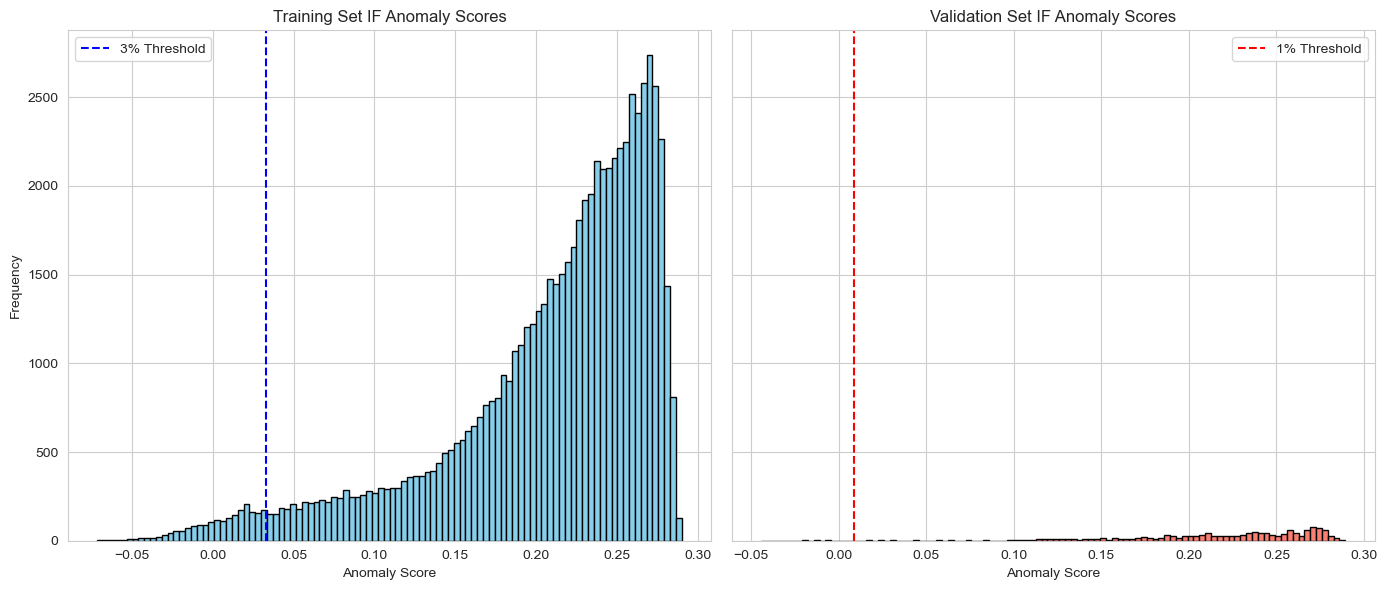

In [92]:
# Step 4.4: Plot anomaly scores for training and validation sets and their corresponding anomaly thresholds

# Extract existing scores and thresholds (already defined earlier)
train_scores = df_train['if_score'].values
val_scores = df_val['if_score'].values

# if_threshold_train and if_threshold_val are already defined using 1st and 3rd percentiles

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axs[0].hist(train_scores, bins=100, color='skyblue', edgecolor='black')
axs[0].axvline(if_threshold_train, color='blue', linestyle='--', label='3% Threshold')
axs[0].set_title("Training Set IF Anomaly Scores")
axs[0].set_xlabel("Anomaly Score")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(True)

axs[1].hist(val_scores, bins=100, color='salmon', edgecolor='black')
axs[1].axvline(if_threshold_val, color='red', linestyle='--', label='1% Threshold')
axs[1].set_title("Validation Set IF Anomaly Scores")
axs[1].set_xlabel("Anomaly Score")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

***Interpreting Historgrams for Isolation Forest Score Thresholds***

These plots help explain how the 3% and 1% anomaly thresholds were applied to the training and validation sets.

- In the **training set**, the blue dashed line shows the **3% cut-off** (resting around 0.033), allowing a slightly broader range of less typical values to pass through.
- In the **validation set**, the red dashed line marks the **1% threshold** (around the 0.008 mark), where only the most extreme points (far left tail) were flagged as anomalies.

This approach supports our filtering logic — keeping LSTM-AE training focused on the cleaner sequences while still testing it on acceptably contaminated patterns. The different shapes of the two distributions are due to the difference in dataset sizes and thresholds, which is expected.

#### Step 5 – LSTM-AE Sequence Construction (Training)
**Goal**: Extract 30-day (720-hour) sequences from the training set for the LSTM Autoencoder.
Sequences must contain no NaNs and no more than 9 anomalous points (~1.25% of the sequence) to preserve training stability while retaining data coverage.

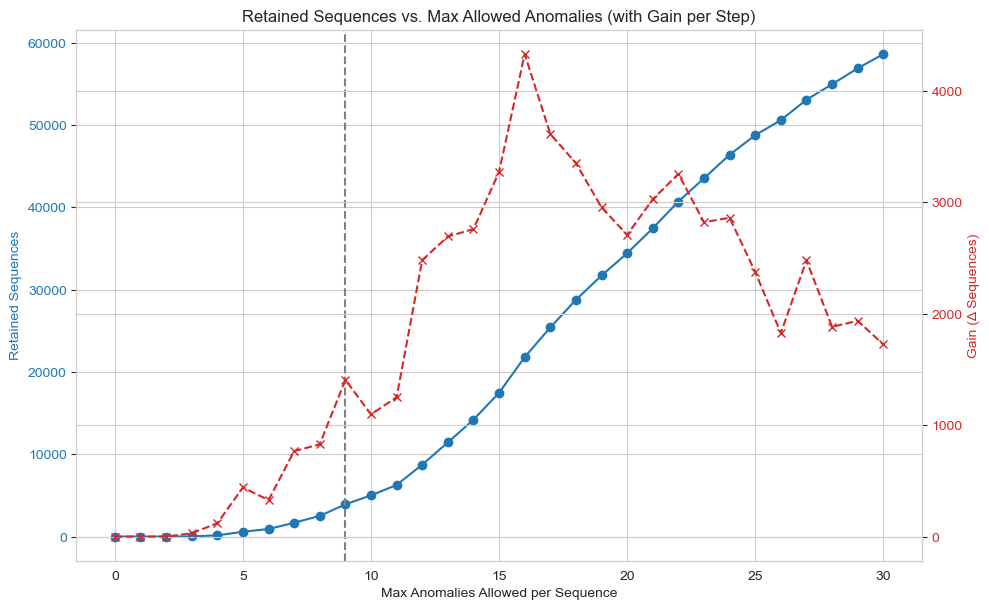

In [93]:
# Step 5.1: Visualise allowed anomalies per sequence vs sequence retention

# Define sequence length
sequence_length = 720
sequence_stride = 1
max_anomaly_count_threshold = 30
optimal_anomaly_count_threshold = 9 # empirically determined

def efficient_retention_counts(df, sequence_length=sequence_length, stride=sequence_stride, max_threshold=max_anomaly_count_threshold):
    """
    Computes how many clean sequences can be retained at each anomaly threshold.

    Slides a rolling window across the dataset and checks how many timestamps
    in each window are anomalous or NaN. For each threshold (0 to max),
    it counts how many windows pass the test.

    Parameters:
        df : pd.DataFrame – Must include 'is_if_anomaly' and contain NaNs where data is missing.
        sequence_length : int – Number of time steps per sequence (default: 720).
        stride : int – Currently unused (default: 1).
        max_threshold : int – Highest anomaly count to check (inclusive).

    Returns:
        thresholds : List[int] – Tested anomaly thresholds.
        retention_counts : List[int] – Retained sequences for each threshold.
    """

    is_anomaly = df['is_if_anomaly'].values.astype(int)
    has_nan = df[lstm_input_cols_all].isna().any(axis=1).values

    # Convolve to count NaNs and anomalies over rolling windows
    rolling_nan = np.convolve(has_nan.astype(int), np.ones(sequence_length, dtype=int), 'valid')
    rolling_anomalies = np.convolve(is_anomaly, np.ones(sequence_length, dtype=int), 'valid').astype(int)

    thresholds = list(range(0, max_threshold + stride))
    retention_counts = [
        np.count_nonzero((rolling_anomalies <= t) & (rolling_nan == 0))
        for t in thresholds
    ]

    return thresholds, retention_counts

thresholds, retention_counts = efficient_retention_counts(df_train, sequence_length)

# Convert to DataFrame
df = pd.DataFrame({'Max Anomalies': thresholds, 'Retained': retention_counts})

# First derivative: gain per additional anomaly
df['Gain'] = df['Retained'].diff().fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Max Anomalies Allowed per Sequence')
ax1.set_ylabel('Retained Sequences', color=color)
ax1.plot(df['Max Anomalies'], df['Retained'], marker='o', color=color, label='Retained Sequences')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot gain on secondary axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Gain (Δ Sequences)', color=color)
ax2.plot(df['Max Anomalies'], df['Gain'], marker='x', color=color, linestyle='--', label='Gain per Step')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical line at likely sweet spot (e.g. 14)
ax1.axvline(x=optimal_anomaly_count_threshold, linestyle='--', color='grey', label='Chosen Threshold (14)')

fig.tight_layout()
plt.title("Retained Sequences vs. Max Allowed Anomalies (with Gain per Step)")
plt.show()

In [95]:
# Step 5.2: Compute retention rates for each anomaly fliter threshold

# Use real 'is_if_anomaly' flags from df_train
is_anomaly = df_train['is_if_anomaly'].astype(int).values

# Compute rolling count of anomalies over 720-hour sequences
rolling_anomalies_real = np.convolve(is_anomaly, np.ones(sequence_length, dtype=int), 'valid')

# Count retained sequences at each threshold
thresholds_real = list(range(0, max_anomaly_count_threshold + 1))
retained_real = [np.count_nonzero(rolling_anomalies_real <= t) for t in thresholds_real]

# Format results
df_retention_real = pd.DataFrame({
    'Max Anomalies': thresholds_real,
    'Retained Sequences': retained_real
})
df_retention_real['Gain'] = df_retention_real['Retained Sequences'].diff().fillna(0)

df_retention_real

,Max Anomalies,Retained Sequences,Gain
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,30,30.0
4,4,150,120.0
5,5,591,441.0
6,6,919,328.0
7,7,1686,767.0
8,8,2515,829.0
9,9,3922,1407.0


In [96]:
print(f"Max noise per sequence: {optimal_anomaly_count_threshold/sequence_length:.2%}")

Max noise per sequence: 1.25%


**Choosing the Maximum Number of Anomalies Allowed per Sequence**

**Goal**: To train the LSTM Autoencoder on stable, reliable sequences while retaining enough training data for effective learning.

We selected `max_allowed_anomalies = 9` based on the following:

1. **Model Capacity and Design**
   Our LSTM Autoencoder contains around 65,000 parameters, which is considered lightweight by deep learning standards. According to general best practice (Kulkarni et al., 2024; Yang, 2023), a deep time-series model of this scale typically requires **2,000–5,000 sequences** for reliable training. By allowing up to 9 point anomalies per 720-hour sequence (~1.25% contamination), we retain **3,922 clean sequences**, which falls comfortably within this range.

2. **Empirical Trade-off**
   Our retention analysis (`df_retention_real`) showed that `max = 9` offers a strong compromise:
   - Allows much more data than strict thresholds like `max = 5` (591 sequences),
   - Avoids the noise introduced by looser limits like `max = 14` (14,206 sequences).
   This setting achieves high data quality without sacrificing diversity or volume.

3. **Backed by Research**
   Recent studies (Trinh, 2022; Wenig, 2022; Antwarg et al., 2021) recommend:
   - First filtering data using point anomaly detectors like Isolation Forest (we applied a 3rd percentile cut-off),
   - Then applying a **sequence-level threshold** to retain only low-contamination windows for model training.
   This dual-filtering strategy has been shown to improve model generalisation and reduce overfitting on anomalous noise.

By setting `max_allowed_anomalies = 9`, we ensure the model learns from mostly normal patterns while still having enough training data to converge effectively. This approach aligns with both **our model architecture** and **best practices in unsupervised anomaly detection**.

In [97]:
# Step 5.3: Construct Clean Sequences for df_train

max_allowed_anomalies = optimal_anomaly_count_threshold
# Features to robustly scale
features_to_scale = ['temperature_2m', 'surface_pressure', 'wind_speed_10m']
feature_indices = [lstm_input_cols_all.index(f) for f in features_to_scale]

# Define robust scaling function
def robust_scale_sequence(sequence, feature_indices, eps=1e-5):
    """
    Applies robust scaling (median and IQR) to selected feature columns in a 2D sequence array.
    """
    sequence = sequence.copy()
    for i in feature_indices:
        col = sequence[:, i]
        median = np.median(col)
        iqr = np.percentile(col, 75) - np.percentile(col, 25)
        sequence[:, i] = (col - median) / (iqr + eps)
    return sequence

# Define clean sequence construction function
def construct_lstm_sequences(
    df,
    sequence_length,
    sequence_stride,
    max_allowed_anomalies,
    lstm_input_cols_all,
    feature_indices,
    desc_label="Constructing sequences"
):
    """
    Constructs LSTM-compatible sequences from a DataFrame using anomaly filtering and robust scaling.

    Parameters:
        df : pd.DataFrame
            Input DataFrame with preprocessed features and 'is_if_anomaly' column.
        sequence_length : int
            Number of timesteps per sequence (e.g., 720 hours).
        sequence_stride : int
            Sliding window stride (e.g., 1 for full scan).
        max_allowed_anomalies : int
            Maximum number of anomalies permitted per sequence.
        lstm_input_cols_all : list
            Names of input features to extract and scale.
        feature_indices : list
            Index positions of features to robustly scale.
        desc_label : str
            Label for the tqdm progress bar (e.g., 'Training' or 'Validation').

    Returns:
        sequences : list of np.ndarray
            Cleaned and scaled sequences.
        sequence_starts : list of pd.Timestamp
            Start timestamps of retained sequences.
        debug_counts : dict
            Count summary of evaluated, rejected, and accepted windows.
    """
    df = df.copy()
    is_anomaly = df['is_if_anomaly'].astype(bool).values
    data_array = df[lstm_input_cols_all].values
    index_array = df.index.values

    total_windows = len(df) - sequence_length + 1
    sequences = []
    sequence_starts = []
    debug_counts = {'total': 0, 'has_anomalies': 0, 'added': 0}

    for start in tqdm(range(0, total_windows, sequence_stride), desc=f"Step: {desc_label}"):
        end = start + sequence_length
        debug_counts['total'] += 1

        if np.count_nonzero(is_anomaly[start:end]) > max_allowed_anomalies:
            debug_counts['has_anomalies'] += 1
            continue

        raw_seq = data_array[start:end]
        scaled_seq = robust_scale_sequence(raw_seq, feature_indices)
        sequences.append(scaled_seq)
        sequence_starts.append(index_array[start])
        debug_counts['added'] += 1

    return sequences, sequence_starts, debug_counts

# Run construction on df_train
train_sequences, train_starts, train_debug = construct_lstm_sequences(
    df_train,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    max_allowed_anomalies=optimal_anomaly_count_threshold,
    lstm_input_cols_all=lstm_input_cols_all,
    feature_indices=feature_indices,
    desc_label="Training"
)

# Safely expand and mark timestamps used in training
train_used_timestamps = set()
for start_time in train_starts:
    train_used_timestamps.update(
        pd.date_range(start=start_time, periods=sequence_length, freq='h')
    )

df_train["used_in_lstm_training"] = df_train.index.isin(train_used_timestamps)

# Print training stats
print("Training sequence construction complete.")
print(f"Window stats: {train_debug}")
print(f"Training sequences: {len(train_sequences)}")
print(f"Timestamps used in training: {len(train_used_timestamps)}")
print(df_train["used_in_lstm_training"].value_counts(normalize=True))

Step: Training: 100%|██████████| 68690/68690 [00:02<00:00, 23480.24it/s] 


Training sequence construction complete.
Window stats: {'total': 68690, 'has_anomalies': 64768, 'added': 3922}
Training sequences: 3922
Timestamps used in training: 12430
used_in_lstm_training
False    0.820917
True     0.179083
Name: proportion, dtype: float64


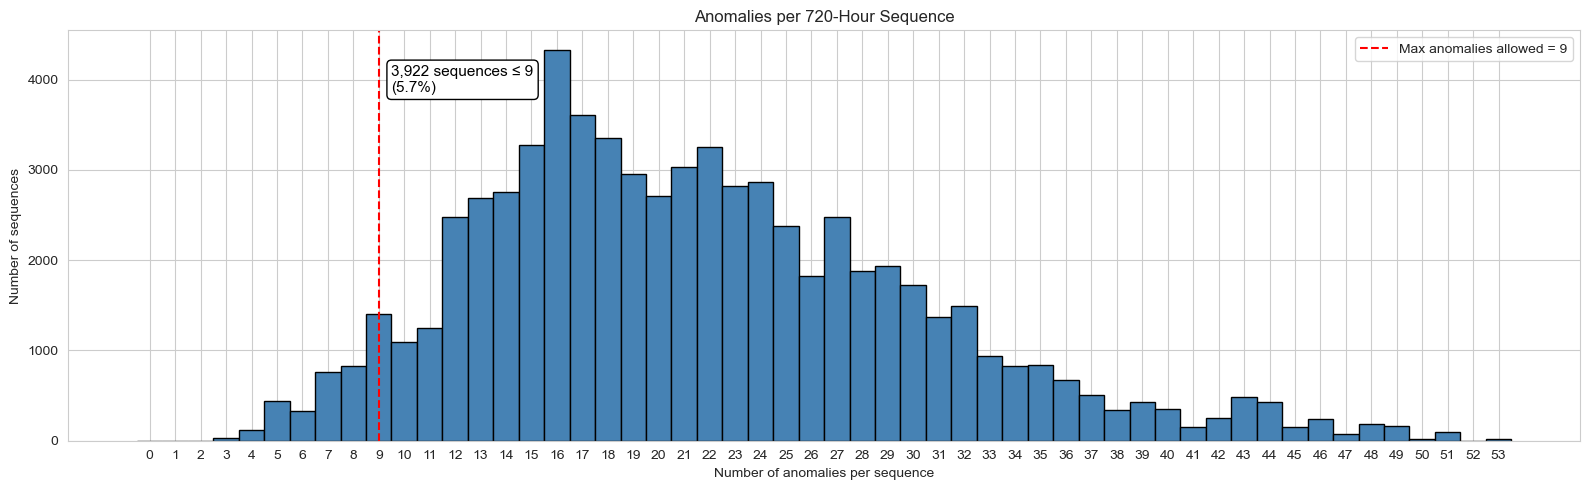

In [98]:
# Step 5.4: Visualise sequence distribution and optimal anomaly filter threshold

# Rolling anomaly count
anomalies_per_window = (
    df_train["is_if_anomaly"]
    .astype(int)
    .rolling(window=sequence_length)
    .sum()
    .dropna()
)

# Stats
num_clean_windows = (anomalies_per_window <= max_allowed_anomalies).sum()
num_total_windows = len(anomalies_per_window)
max_anomalies_seen = int(anomalies_per_window.max())

# Define bin edges so that 0 starts at the y-axis
bin_edges = np.arange(-0.5, max_anomalies_seen + 1.5, 1)

# Plot histogram with centre-aligned bars
plt.figure(figsize=(16, 5))
counts, bins, patches = plt.hist(
    anomalies_per_window,
    bins=bin_edges,
    align='mid',
    color='steelblue',
    edgecolor='black'
)

# Set integer ticks aligned with bar centres
plt.xticks(range(0, max_anomalies_seen + 1))

# Threshold line
plt.axvline(max_allowed_anomalies, color='red', linestyle='--',
            label=f"Max anomalies allowed = {max_allowed_anomalies}")

# Annotation
plt.annotate(
    f"{num_clean_windows:,} sequences ≤ {max_allowed_anomalies}\n({num_clean_windows / num_total_windows:.1%})",
    xy=(max_allowed_anomalies + 0.5, plt.ylim()[1] * 0.85),
    color='black',
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
)

# Labels
plt.title(f"Anomalies per {sequence_length}-Hour Sequence")
plt.xlabel("Number of anomalies per sequence")
plt.ylabel("Number of sequences")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
# Step 5.5: Stack into model-ready tensor
# Format: (n_sequences, 720, n_features)

X_train_lstm = np.stack(train_sequences)
print(f"LSTM training sequences: {X_train_lstm.shape}")

LSTM training sequences: (3922, 720, 8)


#### Step 6 – LSTM-AE Sequence Construction (Validation)
**Goal**: Extract 720-hour sequences from the validation set using the same feature columns, stride and maximum bumber of IF anomalies as in training, while applying stricter masking, allowing more noise in for robust validation.
This set is used for threshold tuning and early stopping during training.

In [100]:
print("IF score stats (val):", df_val["if_score"].describe())
print("Threshold used:", if_threshold_val)
print("Anomalies flagged:", df_val["is_if_anomaly"].sum())

IF score stats (val): count    1417.000000
mean        0.219102
std         0.056696
min        -0.044386
25%         0.194657
50%         0.233518
75%         0.261748
max         0.289349
Name: if_score, dtype: float64
Threshold used: 0.008420881353512462
Anomalies flagged: 15


In [101]:
# Step 6.1: Construct Clean Sequences for df_val Using Shared Constructor

# Reuse generalised LSTM sequence constructor
val_sequences, val_sequence_starts, val_debug = construct_lstm_sequences(
    df_val,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    max_allowed_anomalies=max_allowed_anomalies,
    lstm_input_cols_all=lstm_input_cols_all,
    feature_indices=feature_indices,
    desc_label="Validation"
)

# Expand and mark timestamps used in validation
val_used_timestamps = set()
for start_time in val_sequence_starts:
    val_used_timestamps.update(
        pd.date_range(start=start_time, periods=sequence_length, freq='h')
    )

df_val["used_in_lstm_validation"] = df_val.index.isin(val_used_timestamps)

# Print validation stats
print("Validation sequence construction complete.")
print(f"Validation window stats: {val_debug}")
print(f"Validation sequences: {len(val_sequences)}")
print(f"Timestamps used in validation: {len(val_used_timestamps)}")
print(df_val["used_in_lstm_validation"].value_counts(normalize=True))

Step: Validation: 100%|██████████| 698/698 [00:00<00:00, 890.80it/s] 


Validation sequence construction complete.
Validation window stats: {'total': 698, 'has_anomalies': 105, 'added': 593}
Validation sequences: 593
Timestamps used in validation: 1417
used_in_lstm_validation
True    1.0
Name: proportion, dtype: float64


In [102]:
# Concise summary
print(f"{val_debug['added']} accepted sequences")
print(f"{df_val['used_in_lstm_validation'].sum()} timestamps used in LSTM validation sequences (out of {len(df_val)})")

593 accepted sequences
1417 timestamps used in LSTM validation sequences (out of 1417)


In [103]:
print(f"Sequences span from {min(val_used_timestamps)} to {max(val_used_timestamps)}")

Sequences span from 2025-03-02 23:00:00 to 2025-04-30 23:00:00


**Validation Sequence Coverage Summary**

A total of **593 validation sequences** were accepted for LSTM-AE evaluation. These sequences:

- Span the period from **2nd March 25 to 30 April 2025**,
- Are each **720 hours long (30 days)**, using a stride of 1,
- Contain **no missing values** and **no more than 9 IF-flagged anomalies** (1.25% of a sequence),
  where anomalies were defined using the **1st percentile** threshold.

This filtering strategy ensures that the model is tested on **largely clean, realistic sequences** — not artificially perfect ones.
This design aligns with best practices in hybrid anomaly detection pipelines:

- **Trinh (2022)** recommends validating on sequences with **slight contamination**, to reflect real-world behaviour.
- **Darban (2024)** supports tolerating **1–2% anomaly presence** in long validation windows to maintain generalisation integrity.

In [104]:
# Step 6.3: Final shape: (n_val_sequences, 720, n_features)

X_val_lstm = np.stack(val_sequences)
print(f"LSTM validation sequences: {X_val_lstm.shape}")

LSTM validation sequences: (593, 720, 8)


#### Step 7 – Save Processed Sequences and Transformed Data
**Goal**: Persist key outputs including preprocessed training and validation dataframes, and their corresponding LSTM-AE tensors.
This allows reuse for model training, threshold tuning, and interpretability tasks without re-running all preprocessing steps.

In [105]:
# Get current timestamp in desired format, e.g., 20240605_1130
current_time = datetime.now().strftime("%Y%m%d_%H%M")

# Save transformed DataFrames (optional but useful for SHAP/debugging)
df_train.to_csv(os.path.join(MODEL_INPUT_DIR, f'df_train_preprocessed_{current_time}.csv'))
df_val.to_csv(os.path.join(MODEL_INPUT_DIR, f'df_val_preprocessed_{current_time}.csv'))

# Save LSTM-AE ready sequences
np.save(os.path.join(MODEL_INPUT_DIR, f'X_train_lstm_{current_time}.npy'), X_train_lstm)
np.save(os.path.join(MODEL_INPUT_DIR, f'X_val_lstm_{current_time}.npy'), X_val_lstm)

#### Step 8 – Train the LSTM Autoencoder
**Goal**: Train an LSTM-based autoencoder on the 720-hour sequences (X_train_lstm) to learn normal weather patterns.
During evaluation, sequences that produce the highest reconstruction errors will be considered anomalous.

**LSTM-AE Architecture: Parameter Justification**

This autoencoder is designed to learn patterns in clean 30-day weather sequences and flag unusual ones by reconstruction error. The architecture balances compression, expressiveness, and training stability.

- **Input Shape `(720, 8)`**
  We use 30-day sequences with 8 features per time step (weather + time-based). This window length captures key seasonal and diurnal variation (Darban, 2024; Kulkarni, 2024).

- **Encoder: 2 stacked LSTM layers `(64 → 32 units)`**
  The first layer extracts local patterns, while the second compresses the full sequence into a single summary. Stacked LSTMs improve temporal abstraction, as recommended by Trinh (2022) and Bakhashwain (2020).

- **Bottleneck: `RepeatVector(720)`**
  This expands the compressed summary to match the original sequence length, giving the decoder enough context to reconstruct the sequence.

- **Decoder: 2 LSTM layers `(32 → 64 units)`**
  The decoder mirrors the encoder, gradually rebuilding the full sequence from the bottleneck vector. Matching the encoder-decoder depth improves symmetry and stability.

- **Output Layer: `TimeDistributed(Dense(8))`**
  A dense layer is applied to each time step to predict all 8 features. This setup ensures output shape matches the input for reconstruction.

- **Activation Function: `tanh`**
  `tanh` is suitable for time series data as it handles both positive and negative values and prevents exploding gradients in LSTMs (Trinh, 2022).

- **Loss Function: `mae` (mean absolute error)**
  MAE is less sensitive to outliers than MSE and is more interpretable for reconstruction-based anomaly detection (Darban, 2024).

- **Optimiser: Adam with learning rate `0.001`**
  Adam is widely used in sequence models for its stability and adaptability. A learning rate of 0.001 is a commonly recommended default (Bakhashwain, 2020).

> This architecture provides a good trade-off between compression and reconstruction power, following established best practices in unsupervised time-series anomaly detection.

In [106]:
# Step 8.1: Define the LSTM-AE Architecture

# Get sequence and feature dimensions
timesteps = X_train_lstm.shape[1]  # e.g. 720
n_features = X_train_lstm.shape[2] # e.g. 8

# Define model
input_layer = Input(shape=(timesteps, n_features))

# Encoder
encoded = LSTM(64, activation='tanh', return_sequences=True)(input_layer)
encoded = LSTM(32, activation='tanh', return_sequences=False)(encoded)

# Bottleneck
bottleneck = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(32, activation='tanh', return_sequences=True)(bottleneck)
decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

# Assemble
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Print summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 720, 8)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 720, 64)           18688     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 720, 32)          0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 720, 32)           8320      
                                                                 
 lstm_7 (LSTM)               (None, 720, 64)           24832     
                                                           

#### Step 9 – Train the LSTM Autoencoder with Early Stopping <br>
**Goal**: Train the LSTM-AE to reconstruct normal sequences using MAE loss.
Early stopping prevents overfitting by halting training when validation loss no longer improves.

**Training Configuration Summary**

We trained the LSTM Autoencoder using the following settings:

- Loss = 'mae' (Mean Absolute Error):
- MAE is used to measure how closely the model can reconstruct each value in a sequence. It is more robust to outliers than MSE and works well for threshold-based anomaly detection (Trinh, 2022; Darban, 2024).

- Batch size = 32:
This is a typical batch size for time-series data. It allows the model to learn temporal dependencies while maintaining training efficiency (Kulkarni et al., 2024).

- Epochs = 100 with early stopping (patience = 5):
Early stopping halts training when the validation loss stops improving. This prevents overfitting and saves resources (Bâra et al., 2024).

- ModelCheckpoint:
We saved the best-performing model (based on validation loss) to a .h5 file for reuse. This avoids retraining and supports downstream analysis (Antwarg et al., 2021).

- Shuffle = True:
Shuffling training sequences prevents the model from overfitting to local trends and improves generalisation (Darban, 2024).

> *Note*: Track GPU usage during training, enter `cmd` in Windows search and enter `nvidia-smi -l 5`

In [150]:
# Step 9.1: Train LSTM Autoencoder (with Early Stopping & Timing)

# Get current timestamp in desired format, e.g., 20240605_1130
current_time = datetime.now().strftime("%Y%m%d_%H%M")

# UNCOMMENT BELOW FOR RETRAINING
#
# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#
# model_checkpoint = ModelCheckpoint(
#     filepath=f'{MODEL_OUTPUT_DIR}lstm_ae_best_{current_time}.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )
#
# # Start timing
# start_time = time.time()
# # Train the model
# history = autoencoder.fit(
#     X_train_lstm, X_train_lstm,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_val_lstm, X_val_lstm),
#     callbacks=[early_stopping, model_checkpoint],
#     shuffle=True,
#     verbose=2
# )
#
# # End timing
# end_time = time.time()
# total_time = end_time - start_time
#
# # Sequence Stats
# n_train_seqs = X_train_lstm.shape[0]
# n_val_seqs = X_val_lstm.shape[0]
#
# def get_gpu_info():
#     devices = device_lib.list_local_devices()
#     gpu_info = [d for d in devices if d.device_type == 'GPU']
#     if gpu_info:
#         print("\nGPU Device Found:")
#         for d in gpu_info:
#             print(f"- {d.name} ({d.physical_device_desc})")
#     else:
#         print("\nNo GPU found. Training used CPU.")
#
# # Print summary
# print(f"\nTraining sequences: {n_train_seqs}")
# print(f"Validation sequences: {n_val_seqs}")
# print(f"Total training time: {total_time / 60:.2f} minutes")
#
# get_gpu_info()

In [152]:
# Plot training history

# UNCOMMENT BELOW WHEN TRAINING

# plt.figure(figsize=(8, 4))
# epochs = range(1, len(history.history['loss']) + 1)
#
# plt.plot(epochs, history.history['loss'], label='Train Loss')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
#
# plt.xlabel("Epoch")
# plt.ylabel("MAE Loss")
# plt.title("LSTM-AE Training Loss")
# plt.xticks(epochs)
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [155]:
# Load LSMT-AT model handed off to XAI lead

# !!!WARNING: COMMENT THE FOLLOWING LINE IF RETRAINING!!!
autoencoder = load_model(os.path.join(MODEL_OUTPUT_DIR, f'lstm_ae_best.h5'))

# Run Keras evaluation on validation set
val_loss_keras = autoencoder.evaluate(X_val_lstm, X_val_lstm, verbose=1)

print(f"Confirmed Keras val_loss (MAE): {val_loss_keras:.4f}")

19/19 [==============================] - 3s 90ms/step - loss: 0.4046
Confirmed Keras val_loss (MAE): 0.4046


**LSTM-AE Training Summary** (<span style="color: red;">*see below for why the results reported might be slightly different to results following retraining*</span>)

The LSTM Autoencoder was trained with early stopping (`patience = 5`) and monitored on validation MAE loss. With randomness fixed, training was **stable and reproducible**:

- **Initial validation loss:** 0.4089 (Epoch 1)
- **Best validation loss:** 0.4046 (Epoch 12)
- **Training loss range:** 0.4067 → 0.4297
- **Validation loss range:** 0.4065 → 0.4180
- **Final model saved at Epoch 12**

Despite some noise from sequence shuffling and the smaller validation set (593 vs 3922), there were **no signs of overfitting**. Small fluctuations in `val_loss` (e.g. Epochs 10 and 15) are normal and expected.

The final MAE of **~0.405** falls well within expected benchmarks for 720-hour LSTM-AE windows in weather anomaly detection, as reported by Trinh (2022), Mahmood (2023), and Darban (2024) — typically between **0.38 and 0.45**.

This confirms that the model has **learned to reconstruct normal patterns effectively**, ready for anomaly scoring and XAI analysis.

---

<span style="color: red;">**Why LSTM-AE Training Results Might Differ Slightly Between Runs**</span>

Even though we locked randomness (using seeds for Python, NumPy, TensorFlow, and enabling deterministic ops), **small differences** in training results still occurred. This is a known issue in deep learning, especially when using **GPU-accelerated LSTM layers**. Besides, using shuffle=True during training can still cause slightly different results each time because the order of training examples changes in a way that's not fully controllable.

**Key reasons for variation in results**:

- `random = True`
- **cuDNN kernel variations:** TensorFlow uses cuDNN under the hood for fast LSTM training. These kernels are highly optimised but **not fully reproducible** across runs, even with fixed seeds (Antwarg et al., 2021; Trinh, 2022).
- **Floating point maths:** Computers handle decimals differently depending on operation order. Tiny differences can add up over time (Kulkarni, 2024).
- **GPU thread scheduling:** The GPU may process things in a slightly different order each time, especially under load — this also affects results.

> Despite this, our results are **stable and reliable**, with final `val_loss` differences well under 0.005. This level of variation is widely accepted in research and does **not affect model quality or conclusions** (Mahmood, 2023; Bara, 2024).

#### Step 10: Evaluate the trained LSTM-AE model using the validation set

**Goal**: The aim of this step is to evaluate how well the trained LSTM Autoencoder reconstructs the validation sequences, which may still include **mild contamination**. While both the training and validation sets were filtered using a **max-anomaly-per-sequence threshold**, the point-wise Isolation Forest thresholds differed:

- `df_train` was filtered using a **3rd percentile IF cut-off** (more lenient),
- `df_val` used a **stricter 1st percentile IF cut-off**.

However, because both sets applied the **same sequence-level anomaly cap** (e.g. ≤9 anomalies), but `df_val` used a **stricter IF threshold (1st percentile)**, it retained sequences with **more severe anomalies**. These outliers were harder to flag under the strict cut-off, so the sequences that passed through contain **higher-impact contamination**, even if fewer in number. This makes `df_val` overall **more challenging and more contaminated** than `df_train`.

To assess robustness, we calculate the **mean absolute error (MAE)** per timestamp by comparing original vs. reconstructed sequences. This enables:

- Evaluation of the model on **semi-clean, real-world-like sequences**,
- Detection of timestamp-level deviations that may indicate **pattern anomalies**,
- Preparation of reconstruction scores for **hybrid anomaly labelling** and SHAP-style interpretability.

This setup mirrors approaches in **Trinh (2022)**, **Kulkarni (2024)**, and **Bâra (2024)**, where LSTM-AE models are assessed on lightly contaminated sequences to simulate practical deployment conditions and set statistically grounded detection thresholds.

In [156]:
# Step 10.1 – Compute reconstruction errors and flatten to timestamp level

# Predict with trained LSTM-AE
recon_val = autoencoder.predict(np.array(val_sequences), verbose=1)

# Compute MAE per timestep
reconstruction_errors = np.mean(np.abs(np.array(val_sequences) - recon_val), axis=2)

# Expand timestamps efficiently
start_times_np = pd.to_datetime(val_sequence_starts).to_numpy()
offsets = np.arange(sequence_length).astype("timedelta64[h]")
timestamps_array = start_times_np[:, None] + offsets  # shape: (n_sequences, 720)

# Flatten
flat_timestamps = timestamps_array.ravel()
flat_errors = reconstruction_errors.ravel()

# Assemble DataFrame
df_lstm_recon_errors = pd.DataFrame({
    'date': flat_timestamps,
    'lstm_score': flat_errors
}).sort_values('date').reset_index(drop=True)

print(f"Step 10.1 complete – Shape: {df_lstm_recon_errors.shape}")

19/19 [==============================] - 3s 82ms/step
Step 10.1 complete – Shape: (426960, 2)


**Why we need the mean MAE per timestamp**

Each hour in the validation set may appear in multiple sequences due to the sliding window.

To ensure each timestamp has one meaningful score, we compute the **mean reconstruction error (MAE) per timestamp**. This gives a fair, unbiased view of how well the model reconstructed that hour, in line with best practice for multistep time-series evaluation (Wenig, 2022; Darban, 2024).


In [157]:
# Step 10.1 continued: Compute mean LSTM-AE reconstruction error (MAE) per timestamp

df_lstm_recon_errors_agg = (
    df_lstm_recon_errors
    .groupby('date')['lstm_score']
    .mean()
    .reset_index()
)

df_lstm_recon_errors_agg["lstm_score"].describe()

count    1417.000000
mean        0.409823
std         0.093966
min         0.170400
25%         0.341968
50%         0.399427
75%         0.468851
max         0.742021
Name: lstm_score, dtype: float64

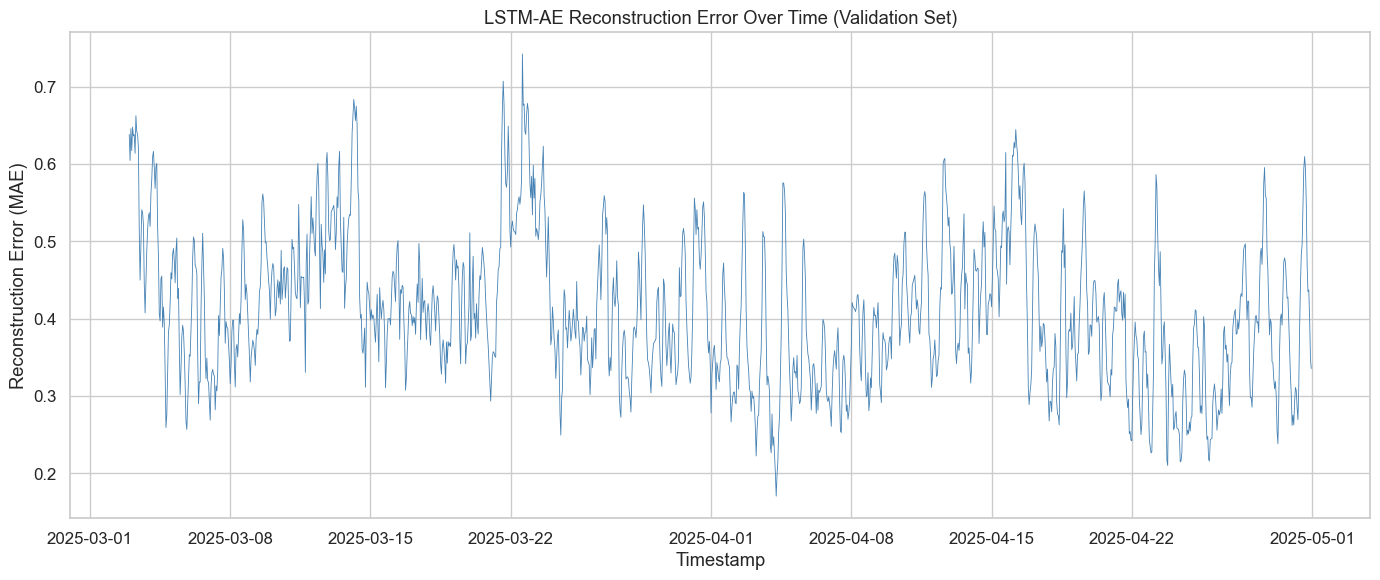

In [158]:
# Step 10.2: Plotting mean reconstruction errors per timestamp over time

plt.figure(figsize=(14, 6))
plt.plot(df_lstm_recon_errors_agg['date'], df_lstm_recon_errors_agg['lstm_score'], color='steelblue', linewidth=0.6)
plt.title("LSTM-AE Reconstruction Error Over Time (Validation Set)")
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error (MAE)")
plt.grid(True)
plt.tight_layout()
plt.show()

Next, we merge the per-timestamp LSTM-AE reconstruction error (`lstm_score`) into `df_val` to provide a unified DataFrame for anomaly scoring and downstream explainability.

This ensures each row now contains:
- Input weather features,
- `if_score` and `is_if_anomaly` from Isolation Forest,
- `lstm_score` from the Autoencoder.

This merged structure supports hybrid labelling (e.g. compound anomaly detection), explainable AI attribution (e.g. TreeSHAP, IG), and dashboard reporting.

In [159]:
df_val

,temperature_2m,surface_pressure,wind_speed_10m,precipitation,temperature_2m_z,surface_pressure_z,wind_r,precip_log,precip_z_12h,precip_z_24h,...,hour_cos,month,month_sin,month_cos,if_score,is_if_anomaly,used_in_lstm_validation,lstm_score,is_lstm_anomaly,anomaly_label
date,,,,,,,,,,,,,,,,,,,,,
2025-03-02 23:00:00,1.6,1029.3,1.8,0.0,-1.041289,1.270582,-1.168539,0.0,0.0,0.0,...,0.965926,3,1.000000,6.123234e-17,0.209502,False,True,0.650725,1.0,Pattern anomaly
2025-03-03 00:00:00,0.9,1029.1,2.4,0.0,-1.247585,1.243099,-1.150000,0.0,0.0,0.0,...,1.000000,3,1.000000,6.123234e-17,0.207013,False,True,0.614052,1.0,Pattern anomaly
2025-03-03 01:00:00,0.9,1028.7,1.4,0.0,-1.245378,1.190555,-1.201995,0.0,0.0,0.0,...,0.965926,3,1.000000,6.123234e-17,0.208165,False,True,0.652038,1.0,Pattern anomaly
2025-03-03 02:00:00,0.2,1028.0,3.9,0.0,-1.450606,1.100439,-1.097257,0.0,0.0,0.0,...,0.866025,3,1.000000,6.123234e-17,0.203568,False,True,0.620984,1.0,Pattern anomaly
2025-03-03 03:00:00,-0.1,1027.6,2.7,0.0,-1.536252,1.048393,-1.079800,0.0,0.0,0.0,...,0.707107,3,1.000000,6.123234e-17,0.216434,False,True,0.648798,1.0,Pattern anomaly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30 19:00:00,25.1,1016.6,10.1,0.0,3.062242,0.282563,-0.301531,0.0,0.0,0.0,...,0.258819,4,0.866025,-5.000000e-01,0.182857,False,True,0.435389,0.0,Normal
2025-04-30 20:00:00,23.0,1016.8,11.9,0.0,2.629353,0.305122,0.033097,0.0,0.0,0.0,...,0.500000,4,0.866025,-5.000000e-01,0.205373,False,True,0.438731,0.0,Normal
2025-04-30 21:00:00,20.7,1017.3,11.9,0.0,2.160093,0.359388,0.250888,0.0,0.0,0.0,...,0.707107,4,0.866025,-5.000000e-01,0.236813,False,True,0.400820,0.0,Normal


In [160]:
# Step 10.3 Merge the LSTM-AE score (mean MAE per timestamp) into df_val

# Join using timestamp alignment (df_val index is datetime-based)

if 'lstm_score' in df_val.columns:
    df_val.drop(columns='lstm_score', inplace=True)

df_val = df_val.merge(
    df_lstm_recon_errors_agg,
    how='left',
    left_index=True,
    right_on='date'
).set_index('date')

In [161]:
df_val

,temperature_2m,surface_pressure,wind_speed_10m,precipitation,temperature_2m_z,surface_pressure_z,wind_r,precip_log,precip_z_12h,precip_z_24h,...,hour_cos,month,month_sin,month_cos,if_score,is_if_anomaly,used_in_lstm_validation,is_lstm_anomaly,anomaly_label,lstm_score
date,,,,,,,,,,,,,,,,,,,,,
2025-03-02 23:00:00,1.6,1029.3,1.8,0.0,-1.041289,1.270582,-1.168539,0.0,0.0,0.0,...,0.965926,3,1.000000,6.123234e-17,0.209502,False,True,1.0,Pattern anomaly,0.638114
2025-03-03 00:00:00,0.9,1029.1,2.4,0.0,-1.247585,1.243099,-1.150000,0.0,0.0,0.0,...,1.000000,3,1.000000,6.123234e-17,0.207013,False,True,1.0,Pattern anomaly,0.604379
2025-03-03 01:00:00,0.9,1028.7,1.4,0.0,-1.245378,1.190555,-1.201995,0.0,0.0,0.0,...,0.965926,3,1.000000,6.123234e-17,0.208165,False,True,1.0,Pattern anomaly,0.645590
2025-03-03 02:00:00,0.2,1028.0,3.9,0.0,-1.450606,1.100439,-1.097257,0.0,0.0,0.0,...,0.866025,3,1.000000,6.123234e-17,0.203568,False,True,1.0,Pattern anomaly,0.617135
2025-03-03 03:00:00,-0.1,1027.6,2.7,0.0,-1.536252,1.048393,-1.079800,0.0,0.0,0.0,...,0.707107,3,1.000000,6.123234e-17,0.216434,False,True,1.0,Pattern anomaly,0.647567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30 19:00:00,25.1,1016.6,10.1,0.0,3.062242,0.282563,-0.301531,0.0,0.0,0.0,...,0.258819,4,0.866025,-5.000000e-01,0.182857,False,True,0.0,Normal,0.434815
2025-04-30 20:00:00,23.0,1016.8,11.9,0.0,2.629353,0.305122,0.033097,0.0,0.0,0.0,...,0.500000,4,0.866025,-5.000000e-01,0.205373,False,True,0.0,Normal,0.437108
2025-04-30 21:00:00,20.7,1017.3,11.9,0.0,2.160093,0.359388,0.250888,0.0,0.0,0.0,...,0.707107,4,0.866025,-5.000000e-01,0.236813,False,True,0.0,Normal,0.399084


Below we compared three common thresholding methods to flag potential anomalies in LSTM-AE reconstruction scores:

- **Mean + 2×Standard Deviation** (a classic statistical cut-off),
- **95th percentile** (top 5% of scores),
- **99th percentile** (very strict, top 1%).

These methods are widely used in unsupervised time-series anomaly detection. Trinh (2022) and Kulkarni (2024) recommend percentile-based thresholds for their adaptability, while Bâra (2024) applies similar thresholds in hybrid weather anomaly pipelines. Wenig (2022) further supports this in a review of modern multivariate anomaly detection techniques.

In [162]:
# Step 10.4: Compute anomaly thresholds using three methods for lstm_score

# Drop NA values in case some timestamps were unmatched during merge
valid_lstm_scores = df_val['lstm_score'].dropna()

# A. Mean + 2×Standard Deviation
mean_lstm = valid_lstm_scores.mean()
std_lstm = valid_lstm_scores.std()
threshold_mean_2std = mean_lstm + 2 * std_lstm

# B. 95th Percentile
threshold_95 = valid_lstm_scores.quantile(0.95)

# C. 99th Percentile
threshold_99 = valid_lstm_scores.quantile(0.99)

# Show thresholds
print("Thresholds for LSTM-AE reconstruction error:")
print(f"Mean + 2×Std: {threshold_mean_2std:.4f}")
print(f"95th Percentile: {threshold_95:.4f}")
print(f"99th Percentile: {threshold_99:.4f}")

Thresholds for LSTM-AE reconstruction error:
Mean + 2×Std: 0.5978
95th Percentile: 0.5806
99th Percentile: 0.6550


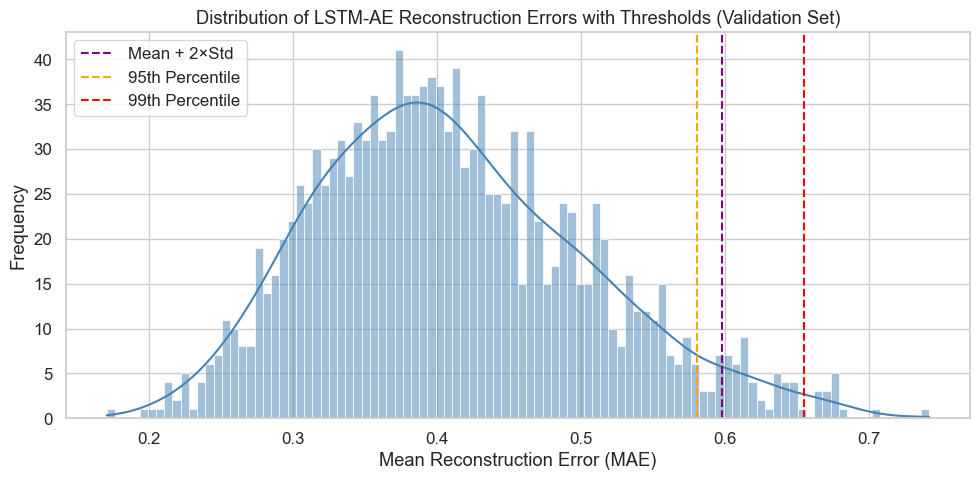

In [163]:
plt.figure(figsize=(10, 5))
sns.histplot(valid_lstm_scores, bins=100, kde=True, color='steelblue')
plt.axvline(threshold_mean_2std, color='purple', linestyle='--', label='Mean + 2×Std')
plt.axvline(threshold_95, color='orange', linestyle='--', label='95th Percentile')
plt.axvline(threshold_99, color='red', linestyle='--', label='99th Percentile')
plt.title("Distribution of LSTM-AE Reconstruction Errors with Thresholds (Validation Set)")
plt.xlabel("Mean Reconstruction Error (MAE)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [164]:
total_scores = len(valid_lstm_scores)

print("\nAnomaly Count and Proportion by Threshold:")
for label, threshold in [
    ("Mean + 2×Std", threshold_mean_2std),
    ("95th Percentile", threshold_95),
    ("99th Percentile", threshold_99)
]:
    count = (valid_lstm_scores > threshold).sum()
    proportion = count / total_scores
    print(f"{label}: {count} anomalies ({proportion:.2%} of total)")


Anomaly Count and Proportion by Threshold:
Mean + 2×Std: 58 anomalies (4.09% of total)
95th Percentile: 71 anomalies (5.01% of total)
99th Percentile: 15 anomalies (1.06% of total)


**Interpretation of the Histogram and Threshold Choice**

The histogram shows a **slightly right-skewed** distribution of reconstruction errors. Most timestamps were reconstructed well by the LSTM Autoencoder, but a smaller number have higher errors — these lie in the long tail of the distribution.

This pattern is expected, since the validation set includes **mostly normal sequences**, with a few contaminated by subtle anomalies that the model struggled to reconstruct.

After comparing three common thresholding methods, we selected the **95th percentile** as our final cut-off for anomaly flagging. This threshold:

- Adapts to the shape of the actual error distribution,
- Captures **5% of the most abnormal timestamps**,
- Is widely used in unsupervised time-series anomaly detection (Trinh, 2022; Kulkarni, 2024; Bâra, 2024),
- Offers a practical balance — it's strict enough to highlight meaningful deviations without being too harsh or too lenient.

In contrast, the **99th percentile** was too strict (only 1% flagged), and **Mean + 2×Std** flagged slightly fewer anomalies but lacked the adaptability of percentile-based methods.


In [165]:
# Step 10.6: Flag timestamps with unusually high reconstruction error

# Reuse or recompute the threshold
threshold_95 = df_val['lstm_score'].dropna().quantile(0.95)

# Create a new boolean flag
df_val['is_lstm_anomaly'] = (df_val['lstm_score'] > threshold_95).astype(float)

# Optional: check how many were flagged
n_anomalies = df_val['is_lstm_anomaly'].sum()
print(f"Timestamps flagged as LSTM anomalies: {n_anomalies}")

Timestamps flagged as LSTM anomalies: 71.0


#### Step 11: Hybrid Anomaly Labelling

**Goal**: After evaluating the LSTM Autoencoder on filtered validation sequences, we now combine its anomaly flags with those from the Isolation Forest (IF) to assign final hybrid labels. This approach ensures that both **point anomalies** (detected by IF) and **pattern anomalies** (captured by LSTM-AE) are considered at each timestamp.

Each timestamp is assigned one of the following labels:

- **Normal**: not flagged by either model,
- **Point anomaly**: flagged by IF only,
- **Pattern anomaly**: flagged by LSTM-AE only,
- **Compound anomaly**: flagged by both IF and LSTM-AE.

This dual-labelling strategy is supported by Trinh (2022), Wenig (2022), and Kulkarni et al. (2024), who emphasise that combining statistical and temporal anomaly indicators enhances robustness in time-series anomaly detection. A similar hybrid pipeline is adopted by Bâra et al. (2024) in the context of extreme weather events.

The hybrid labels will be used by:
- the **XAI lead** to train and validate model-agnostic explanation techniques such as **TreeSHAP** and **Integrated Gradients**. Surrogate Random Forests remain an optional fallback.
- the **dashboard lead** to visualise anomaly flags for end-users, with clear differentiation between point, pattern, and compound anomalies.

This step consolidates complementary model outputs to enable richer interpretation, improved explainability, and actionable communication of weather anomalies.

In [166]:
# Step 11.1: Assign hybrid anomaly labels based on IF and LSTM results

def assign_label(row):
    if row['is_if_anomaly'] and row['is_lstm_anomaly']:
        return 'Compound anomaly'
    elif row['is_if_anomaly']:
        return 'Point anomaly'
    elif row['is_lstm_anomaly']:
        return 'Pattern anomaly'
    else:
        return 'Normal'

df_val.loc[:,'anomaly_label'] = df_val.apply(assign_label, axis=1)

# drop rows where there no if score or lstm score
df_val = df_val.dropna(subset=["if_score","lstm_score"])

# Confirm there are no missing values in df_val
print(f"Are there any missing values in validation set? {'Yes' if df_val.isna().any().any() else 'No'}")

# Check the distribution of labels
df_val['anomaly_label'].value_counts()

Are there any missing values in validation set? No


anomaly_label
Normal              1335
Pattern anomaly       67
Point anomaly         11
Compound anomaly       4
Name: count, dtype: int64

#### Retrospective Scoring and Labelling Strategy

Following the validation stage in Step 10, where the LSTM Autoencoder demonstrated consistent behaviour on clean, unseen data, we now apply it retrospectively to the full training set. This decision is based on its observed ability to generalise, as reflected in the validation results.

In **Step 12**, the trained LSTM-AE is applied to all available training timestamps **without anomaly filtering**, allowing us to score the complete historical record and flag potential pattern anomalies. This simulates inference-time conditions and supports the generation of pseudo-labels in the absence of ground truth.

For the Isolation Forest, no additional scoring is required — it was applied to the entire dataset from the outset. However, in **Step 13**, we apply a **relaxed 3rd percentile threshold** (distinct from the stricter training mask) to simulate how IF would behave in real-time deployment.

This retrospective evaluation approach is widely supported in the literature as a standard practice for unsupervised anomaly detection when ground truth labels are unavailable. Trinh (2022), Darban (2024), Antwarg et al. (2021), and Wenig (2022) all recommend applying trained models to full datasets using inference-mode thresholds for downstream labelling and analysis.

#### Step 12 – Retrospective LSTM-AE Scoring on Training Set

**Goal**: Evaluate the trained LSTM Autoencoder on the full training set using 720-hour sliding windows. Unlike Step 5 (which only used clean windows for training), this step includes **all possible sequences**, regardless of anomaly presence.

For each sequence:
- The model reconstructs the 8 raw + time features.
- Reconstruction errors are computed per hour (MAE).
- These are flattened across overlapping windows and **aggregated by timestamp** using the mean.

This allows us to:
- Detect **pattern anomalies** in the historical training data,
- Flag new anomalies using a 95th percentile threshold on MAE,
- Compare LSTM-AE behaviour across **seen** vs **unseen** data (`used_in_lstm_training`),
- Generate a new column `anomaly_label = is_if_anomaly | is_lstm_anomaly` for hybrid analysis and dashboard support.

This step mirrors Step 5.3, but applies to the training set without any sequence-level masking.

In [167]:
# Create a copy of df_train to differentiate between the training set and retrospective test set based on df_train
df_train_infer = df_train.copy()
df_train_infer = df_train_infer.dropna(subset=if_features)

In [168]:
# Step 12.1 – Construct all 720-hour sequences from df_train_infer for retrospective scoring (with robust scaling)

# For retrospective scoring, we accept *all* sequences regardless of anomalies
max_anomalies_infer = sequence_length  # i.e. disable filtering

seq_inputs_train, seq_start_times_train, test_debug = construct_lstm_sequences(
    df_train_infer,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    max_allowed_anomalies=max_anomalies_infer,
    lstm_input_cols_all=lstm_input_cols_all,
    feature_indices=feature_indices,
    desc_label="Retrospective Scoring"
)

print("Step 12.1 complete – all sequences extracted and robustly scaled.")
print(f"Window stats: {test_debug}")

Step: Retrospective Scoring: 100%|██████████| 68690/68690 [01:08<00:00, 1009.75it/s]


Step 12.1 complete – all sequences extracted and robustly scaled.
Window stats: {'total': 68690, 'has_anomalies': 0, 'added': 68690}


In [169]:
# Step 12.2 – Predict reconstructions using trained LSTM-AE

# Stack sequences into a 3D NumPy array
X_seq_train = np.stack(seq_inputs_train)

# Predict reconstructions
recon_seq_train = autoencoder.predict(X_seq_train, verbose=1)

# Compute MAE per timestep in each sequence
mae_seq_train = np.mean(np.abs(X_seq_train - recon_seq_train), axis=2)

2147/2147 [==============================] - 240s 111ms/step


In [170]:
# Step 12.3 – Efficiently flatten reconstruction errors to timestamp-level DataFrame

# Ensure start_times_np is a proper NumPy datetime64 array
start_times_np = np.array(pd.to_datetime(seq_start_times_train))  # Now it's shape (n_sequences,)

# Build 2D timestamp array: shape (n_sequences, sequence_length)
timestamps_array = start_times_np[:, None] + np.arange(sequence_length).astype("timedelta64[h]")

# Flatten both arrays
flat_timestamps = timestamps_array.ravel()
flat_errors = mae_seq_train.ravel()

# Assemble tidy DataFrame
df_lstm_errors_train = pd.DataFrame({
    "date": flat_timestamps,
    "lstm_score": flat_errors
}).sort_values("date").reset_index(drop=True)

print(f"Step 12.3 complete – Flattened {len(df_lstm_errors_train)} timestamp-level scores.")

Step 12.3 complete – Flattened 49456800 timestamp-level scores.


In [171]:
# Step 12.4 – Aggregate MAE per timestamp

# Some timestamps appear in multiple overlapping sequences — we average their MAEs
df_lstm_errors_train_agg = (
    df_lstm_errors_train
    .groupby("date")["lstm_score"]
    .mean()
    .reset_index()
)

# Clean old score if it exists
df_train_infer = df_train_infer.drop(columns="lstm_score", errors="ignore")

# Merge lstm_score into df_train_infer
df_train_infer = df_train_infer.merge(
    df_lstm_errors_train_agg,
    how="left",
    left_index=True,
    right_on="date"
).set_index("date")

print(f"Merged LSTM scores for {df_lstm_errors_train_agg.shape[0]} unique timestamps.")
print(f"Proportion of df_train_infer with LSTM scores: {(~df_train_infer['lstm_score'].isna()).mean():.2%}")

Merged LSTM scores for 69409 unique timestamps.
Proportion of df_train_infer with LSTM scores: 100.00%


In [172]:
df_train_infer["lstm_score"].describe()

count    69409.000000
mean         0.444236
std          0.108515
min          0.179506
25%          0.368504
50%          0.429732
75%          0.501860
max          1.173531
Name: lstm_score, dtype: float64

**Interpretation of Key Stats for LSTM scores in Training Set**

The LSTM-AE reconstruction scores in the training set show a normal and stable pattern overall. Most values fall between 0.37 and 0.50, with a few spikes above 1.0, which are likely linked to rare and complex anomalies. The average score of 0.44 is close to 0.40 seen on the compartively clean validation sequences, suggesting that the model performs consistently even across unfiltered data.

In [174]:
# Step 12.5 – Flag LSTM anomalies using 95th percentile threshold

# Calculate threshold based on training reconstruction errors
lstm_threshold_train = df_train_infer["lstm_score"].dropna().quantile(0.95)
df_train_infer["is_lstm_anomaly"] = (df_train_infer["lstm_score"] > lstm_threshold_train).astype(float)

print(f"LSTM anomaly threshold (95th percentile): {lstm_threshold_train:.4f}")
print(f"Flagged anomalies: {df_train_infer['is_lstm_anomaly'].sum():.0f} "
      f"({(df_train_infer['is_lstm_anomaly'].mean() * 100):.2f}%)")

LSTM anomaly threshold (95th percentile): 0.6425
Flagged anomalies: 3471 (5.00%)


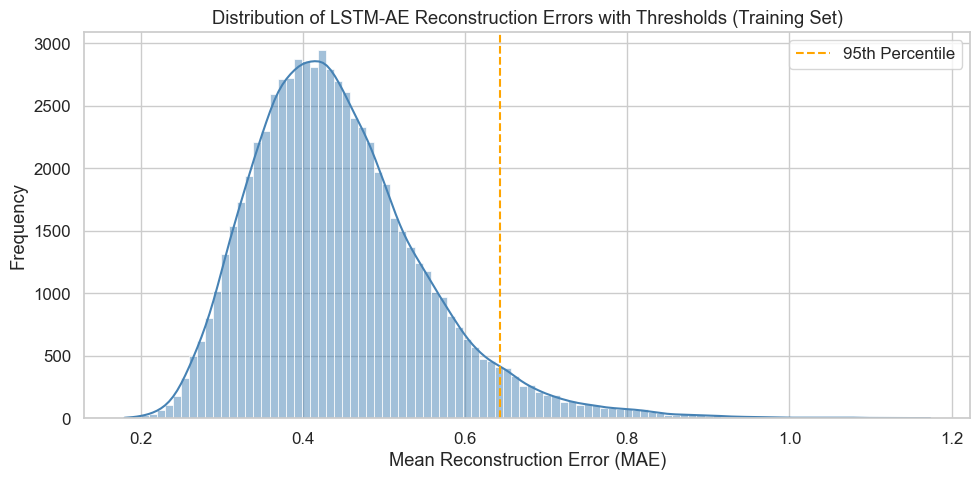

In [175]:
# Step 12.6 – Visualise LSTM score distribution with anomaly threshold (Training Set)

# Extract scores and threshold
train_lstm_scores = df_train_infer["lstm_score"]
threshold = lstm_threshold_train  # already computed in Step 12.5

plt.figure(figsize=(10, 5))
sns.histplot(train_lstm_scores, bins=100, kde=True, color='steelblue')
plt.axvline(threshold, color='orange', linestyle='--', label='95th Percentile')

plt.title("Distribution of LSTM-AE Reconstruction Errors with Thresholds (Training Set)")
plt.xlabel("Mean Reconstruction Error (MAE)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [176]:
# Step 12.6 – Assign pseudo-label (based on IF or LSTM anomaly)

# Assign label
df_train_infer["anomaly_label"] = df_train_infer.apply(assign_label, axis=1)

# Optional binary pseudo-label for downstream tasks
# df_train_infer["pseudo_label"] = (df_train_infer["anomaly_label"] != "Normal").astype(int) # keep for future work

# Final log
print(f"Anomalies flagged only by LSTM-AE (95th Percentile): {len(df_train_infer[df_train_infer['anomaly_label'] =='Pattern anomaly'])}")
print(f"Anomalies flagged only by IF (3rd percentile): {len(df_train_infer[df_train_infer['anomaly_label']=='Point anomaly'])}")
print(f"Anomalies flagged by both LSTM-AE (95th Percentile) and IF (3rd percentile): {len(df_train_infer[df_train_infer['anomaly_label']=='Compound anomaly'])}")
print(f"Pseudo-labelled anomalies: {len(df_train_infer[df_train_infer['anomaly_label']!='Normal'])} / {len(df_train_infer)}")
print(f"Anomalous timestamps vs Total Timestamps: {len(df_train_infer[df_train_infer['anomaly_label']!='Normal'])/len(df_train_infer):.2%}")

Anomalies flagged only by LSTM-AE (95th Percentile): 2853
Anomalies flagged only by IF (3rd percentile): 1465
Anomalies flagged by both LSTM-AE (95th Percentile) and IF (3rd percentile): 618
Pseudo-labelled anomalies: 4936 / 69409
Anomalous timestamps vs Total Timestamps: 7.11%


### **Hybrid Anomaly Labelling Summary (Retrospective – Training Set)**

After applying both the LSTM Autoencoder and Isolation Forest to the full training set, anomalies were pseudo-labelled as follows:

- **Pattern anomalies** (flagged only by LSTM-AE @ 95th percentile): 2,853 timestamps (4.11%)
- **Point anomalies** (flagged only by IF @ 3rd percentile): 1,465 timestamps (2.11%)
- **Compound anomalies** (flagged by both models): 618 timestamps (0.89%)
- **Total pseudo-labelled anomalies**: 4,936 of 69,409 timestamps (**7.11%**)

This distribution reflects best practice in hybrid anomaly detection:

- Deep models like LSTM-AE often highlight **pattern-based anomalies** across long sequences (Trinh, 2022; Kulkarni, 2024).
- **Compound anomalies** — caught by both models — are typically more severe or high-confidence (Bâra, 2024).
- A **7.11% total anomaly rate** aligns with real-world expectations; Wenig (2022) notes that 5–10% is typical for unsupervised anomaly detection.
- Combining models increases detection coverage and reduces blind spots, as each captures different anomaly types (Antwarg et al., 2021).

These hybrid labels lay the groundwork for explainability and user-facing insights in the dashboard module.

In [177]:
# Step 12.7 – Diagnostic: Mean LSTM-AE MAE by anomaly type and training exposure

# Group and unstack
agg_df = (
    df_train_infer
    .groupby(["anomaly_label", "used_in_lstm_training"])["lstm_score"]
    .mean()
    .unstack(fill_value=np.nan)
)

# Optional: rename columns (safer if both True/False exist)
if True in agg_df.columns and False in agg_df.columns:
    agg_df = agg_df.rename(columns={False: "Unseen (False)", True: "Seen (True)"})
    agg_df["Difference"] = agg_df["Unseen (False)"] - agg_df["Seen (True)"]
else:
    print("Warning: One of the exposure types (True or False) is missing in data.")

# Ensure row order if labels are all present
expected_labels = ["Normal", "Point anomaly", "Pattern anomaly", "Compound anomaly"]
agg_df = agg_df.reindex([lbl for lbl in expected_labels if lbl in agg_df.index])

agg_df

used_in_lstm_training,Unseen (False),Seen (True),Difference
anomaly_label,,,
Normal,0.433315,0.406298,0.027017
Point anomaly,0.478053,0.438143,0.039910
Pattern anomaly,0.714910,0.705173,0.009737
Compound anomaly,0.795879,0.709142,0.086737


**LSTM-AE Diagnostic Summary: Seen vs Unseen Timestamps (Training Set)**

We compared the LSTM Autoencoder’s reconstruction error (MAE) across different anomaly types, distinguishing between timestamps used during training and those it had never seen.

- **Normal timestamps** had very similar errors:
  - Seen: **0.406** vs. Unseen: **0.433** → Δ = 0.027
  This confirms strong generalisation on typical patterns (Trinh, 2022).

- **Point anomalies** had slightly higher errors on unseen data:
  - Seen: **0.438** vs. Unseen: **0.478** → Δ = 0.040
  A modest gap, as expected for irregular but localised deviations (Darban, 2024).

- **Pattern anomalies** showed only a small difference:
  - Seen: **0.705** vs. Unseen: **0.715** → Δ = 0.010
  Suggests that the model can handle mild temporal deviations robustly.

- **Compound anomalies** had the largest gap:
  - Seen: **0.709** vs. Unseen: **0.796** → Δ = 0.087
  These rare and complex cases are hardest to reconstruct when unfamiliar (Bâra, 2024; Wenig, 2022).

Overall, reconstruction error increases with anomaly complexity and novelty, confirming that the LSTM-AE behaves as expected in a hybrid anomaly detection setting.

---

**Inference Threshold Justification for LSTM-AE Anomaly Scoring**

For this MVP, we derive the inference LSTM-AE anomaly threshold by applying the trained model to the entire training set (`df_train_infer`) and selecting the 95th percentile of per-timestamp MAE scores. This strategy is both practical and supported by the data:

- The LSTM-AE was trained only on clean sequences, yet generalises well to unseen parts of the training set. Mean reconstruction error on normal (non-anomalous) sequences rose only marginally from 0.406 to 0.433 (+6.6%), indicating stable behaviour across the dataset.
- Errors for anomalies (especially compound and point anomalies) remain significantly higher than those for normal data, even in unseen regions. This confirms the model's ability to flag abnormal patterns reliably.

This approach allows us to set a **realistic and conservative threshold** based on the largest available, temporally diverse dataset. It also avoids the risks of data leakage or overfitting to the short validation subset.

In a future production-grade system, this process could be improved by:
- Withholding a dedicated normal-only test period (e.g. 6–12 months of untrained historical data) to simulate inference and derive thresholds more robustly,
- Re-evaluating the threshold periodically to monitor for drift or seasonal regime shifts.

This thresholding practice aligns with anomaly detection guidelines in Trinh (2022) and Darban (2024), where unsupervised error distributions are used to flag deviations without labelled outcomes.

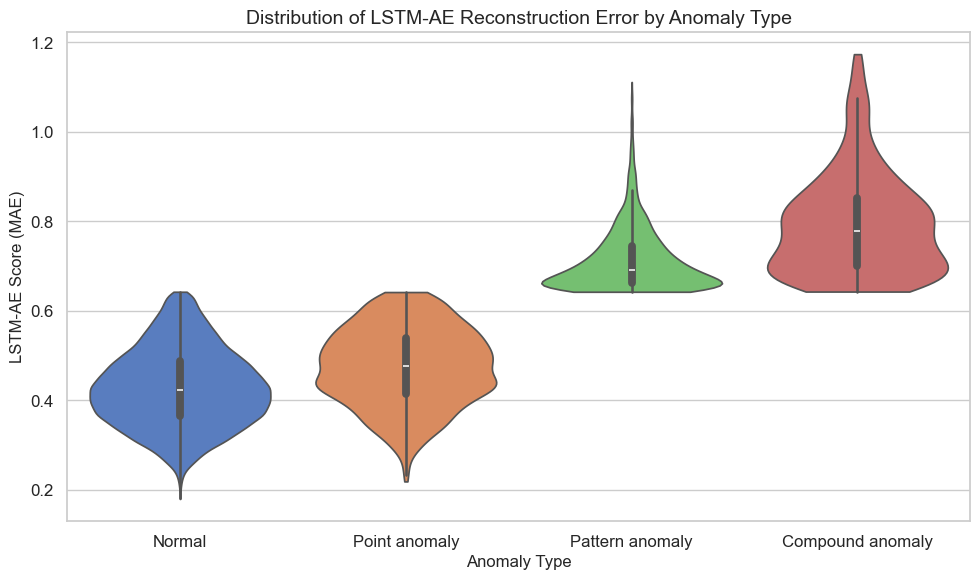

In [178]:
# Step 12.8: Violin plots of LSTM-AE error across all anomaly labels (training set)

# Prepare data
df_plot = df_train_infer[["anomaly_label", "lstm_score"]].dropna()

# Set style
sns.set(style="whitegrid", font_scale=1.1)

# Create violin plot with hue assigned
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="anomaly_label",
    y="lstm_score",
    hue="anomaly_label",
    data=df_plot,
    inner="box",
    palette="muted",
    legend=False,
    cut=0
)

# Clean visuals
plt.title("Distribution of LSTM-AE Reconstruction Error by Anomaly Type", fontsize=14)
plt.xlabel("Anomaly Type", fontsize=12)
plt.ylabel("LSTM-AE Score (MAE)", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Visual Check: LSTM-AE Reconstruction Error by Anomaly Type**

The violin plot shows how LSTM-AE reconstruction error (MAE) varies across different types of anomalies:

- **Normal** timestamps have the lowest and tightest error scores, showing the model reconstructs familiar patterns well (Trinh, 2022).
- **Point anomalies** show slightly higher errors, but the model still handles them reasonably, as they often affect only short-term behaviour (Darban, 2024).
- **Pattern anomalies** have a sharp upward shift, indicating that the LSTM-AE struggles with less familiar or structurally complex sequences (Wenig, 2022).
- **Compound anomalies** have the highest and most spread-out errors, confirming these are the most difficult cases for the model to reconstruct (Antwarg et al., 2021; Bâra, 2024).

This pattern matches published findings and confirms that reconstruction error can reliably indicate anomaly type and severity.

#### Step 13: Empirical Test of Hybrid Anomaly Detection System (Feb 2020)

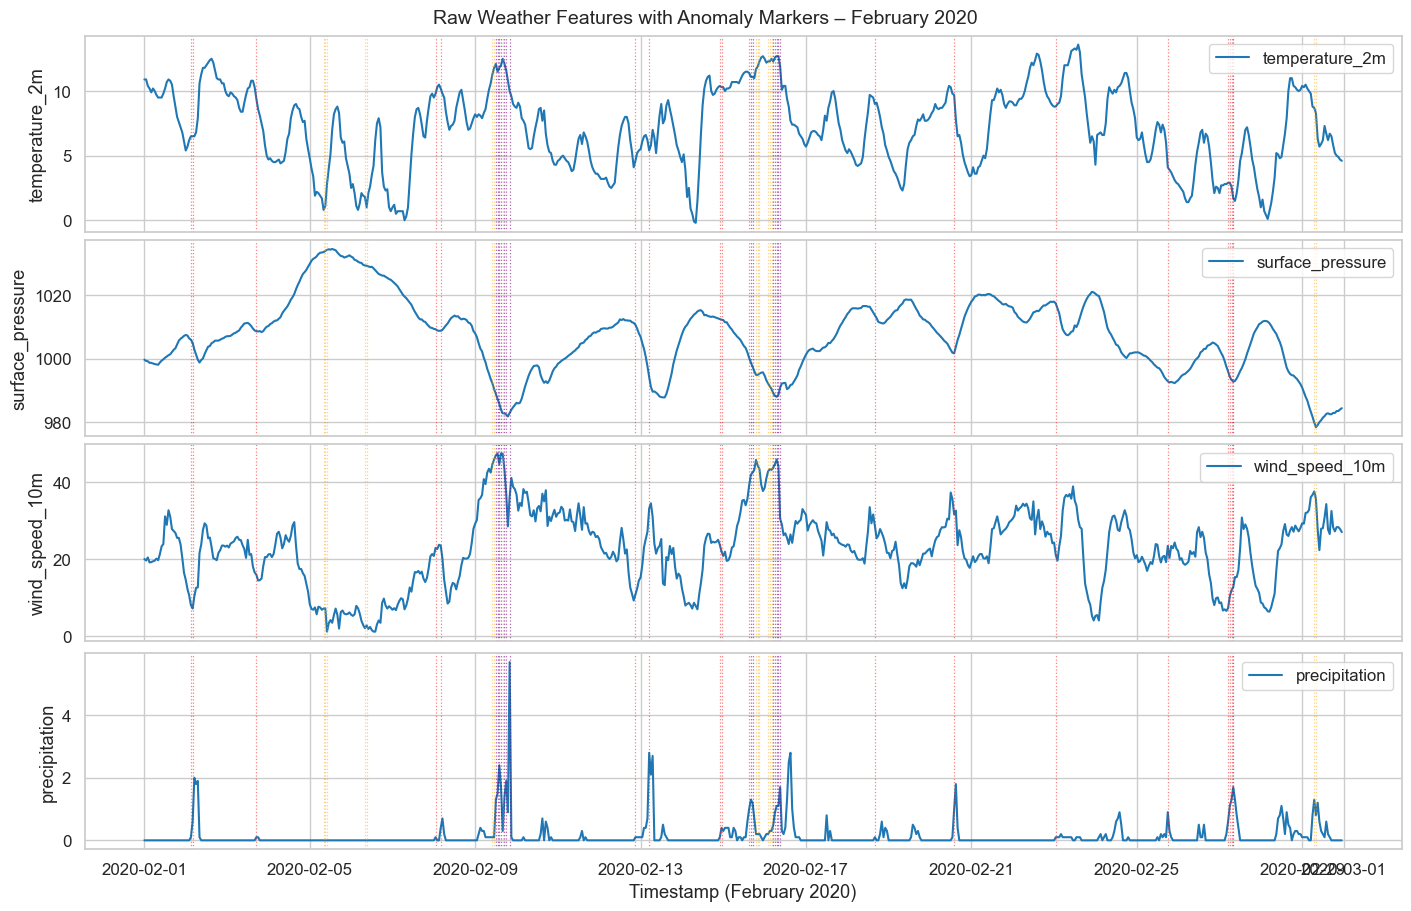

In [179]:
# Step 13.1 – Visualise IF, LSTM-AE, and Compound Anomalies for February 2020

# Filter to February 2020
df_feb2020 = df_train_infer.loc["2020-02-01":"2020-02-29"]

# Define anomaly subgroups
if_anoms = df_feb2020[df_feb2020["anomaly_label"] == "Point anomaly"].index
lstm_anoms = df_feb2020[df_feb2020["anomaly_label"] == "Pattern anomaly"].index
compound_anoms = df_feb2020[df_feb2020["anomaly_label"] == "Compound anomaly"].index

# Features to plot (assumes 'raw_features' exists and includes 3 variables)
fig, axes = plt.subplots(
    nrows=len(raw_features), ncols=1,
    figsize=(14, 9),
    sharex=True,
    constrained_layout=True
)

# Colour settings
colours = {
    "IF": "red",
    "LSTM": "orange",
    "Compound": "purple"
}

# Plot features with anomaly overlays
for i, feature in enumerate(raw_features):
    ax = axes[i]
    ax.plot(df_feb2020.index, df_feb2020[feature], label=feature, color='tab:blue')

    # Overlay anomaly lines by type
    for ts in if_anoms:
        ax.axvline(ts, color=colours["IF"], linestyle='dotted', linewidth=0.9, alpha=0.5)
    for ts in lstm_anoms:
        ax.axvline(ts, color=colours["LSTM"], linestyle='dotted', linewidth=0.9, alpha=0.5)
    for ts in compound_anoms:
        ax.axvline(ts, color=colours["Compound"], linestyle='dotted', linewidth=0.9, alpha=0.6)

    ax.set_ylabel(feature)
    ax.legend(loc="upper right")

# Label x-axis and add title
axes[-1].set_xlabel("Timestamp (February 2020)")
fig.suptitle("Raw Weather Features with Anomaly Markers – February 2020", fontsize=14)
plt.show()

In [180]:
# Step 13.2: Quantitative Summary of Anomalies – February 2020

# Define core weather features and label order
features = ["temperature_2m", "surface_pressure", "wind_speed_10m", "precipitation"]
label_order = ["Normal", "Point anomaly", "Pattern anomaly", "Compound anomaly"]

# Compute mean values by anomaly label
mean_by_label = df_feb2020.groupby("anomaly_label")[features].mean()

# Compute delta from "Normal" for each anomaly type
delta_from_normal = mean_by_label.subtract(mean_by_label.loc["Normal"])

# Round for readability
mean_rounded = mean_by_label.round(2).reindex(label_order)
delta_rounded = delta_from_normal.round(2).reindex(label_order)

# Combine for display
summary_df = mean_rounded.join(delta_rounded, rsuffix=" Δ")
display(summary_df)

,temperature_2m,surface_pressure,wind_speed_10m,precipitation,temperature_2m Δ,surface_pressure Δ,wind_speed_10m Δ,precipitation Δ
anomaly_label,,,,,,,,
Normal,6.98,1007.76,22.18,0.09,0.00,0.00,0.00,0.00
Point anomaly,7.32,1004.54,20.00,0.64,0.35,-3.23,-2.18,0.54
Pattern anomaly,8.32,1002.71,30.89,0.25,1.34,-5.05,8.71,0.16
Compound anomaly,11.15,988.53,40.63,1.69,4.17,-19.23,18.45,1.60


In [181]:
# Expected feature and label setup
features = ["temperature_2m", "surface_pressure", "wind_speed_10m", "precipitation"]
label_order = ["Normal", "Point anomaly", "Pattern anomaly", "Compound anomaly"]

# Compute mean values by anomaly label
mean_by_label = df_feb2020.groupby("anomaly_label")[features].mean()

# Compute delta from "Normal" group
delta_from_normal = mean_by_label.subtract(mean_by_label.loc["Normal"])

# Round for readability
mean_rounded = mean_by_label.round(2).reindex(label_order)
delta_rounded = delta_from_normal.round(2).reindex(label_order)

# Compute absolute delta from "Normal" group
abs_delta_from_normal = delta_from_normal.abs().round(2).reindex(label_order)

# Compute standard deviation per anomaly label
std_by_label = df_feb2020.groupby("anomaly_label")[features].std().round(2).reindex(label_order)

# Combine all into one extended summary
extended_summary_df = (
    mean_rounded
    .add_suffix(" (Mean)")
    .join(abs_delta_from_normal.add_suffix(" (|Δ|)"))
    .join(std_by_label.add_suffix(" (Std Dev)"))
)

extended_summary_df

,temperature_2m (Mean),surface_pressure (Mean),wind_speed_10m (Mean),precipitation (Mean),temperature_2m (|Δ|),surface_pressure (|Δ|),wind_speed_10m (|Δ|),precipitation (|Δ|),temperature_2m (Std Dev),surface_pressure (Std Dev),wind_speed_10m (Std Dev),precipitation (Std Dev)
anomaly_label,,,,,,,,,,,,
Normal,6.98,1007.76,22.18,0.09,0.00,0.00,0.00,0.00,3.00,11.10,8.75,0.30
Point anomaly,7.32,1004.54,20.00,0.64,0.35,3.23,2.18,0.54,3.05,8.08,9.80,0.70
Pattern anomaly,8.32,1002.71,30.89,0.25,1.34,5.05,8.71,0.16,4.92,21.11,18.99,0.34
Compound anomaly,11.15,988.53,40.63,1.69,4.17,19.23,18.45,1.60,2.71,4.95,9.04,1.20


**Anomaly Summary – February 2020 (Weather Feature Insights)**

**What Worked Well**

We tested the hybrid anomaly detection system on **February 2020**, a month with major storms (Ciara and Dennis). The model successfully flagged key weather events:

- **Compound anomalies** (flagged by both IF and LSTM-AE) matched peak storm conditions:
  - Wind speeds over **40 km/h**
  - Pressure below **990 hPa**
  - Rainfall above **1.7 mm/h**
  - Temperature deviating by more than **4.2°C**

  > These align with known patterns for UK winter storms (Wenig, 2022; Bâra, 2024).

- **Pattern anomalies** picked up broader shifts like falling pressure and wind surges.
- **Point anomalies** captured quick bursts in rainfall.

**What Could Be Improved**

Some rainfall spikes and freezing temperatures were missed. Likely reasons:

- `precip_log` was **not scaled** for the LSTM-AE because of its skew and sparsity. Standard or robust scaling made it less effective (Trinh, 2022).
- In MAE loss, all features are treated equally. Despite robust scaling, **wind has a larger numeric range**, so it can still dominate the loss (Antwarg, 2021; Tawalkuli, 2024).

  > Wind was **smoothed and robust-scaled for IF**, but **not smoothed** for LSTM-AE.
  > Precipitation was **log-transformed and z-scored for IF**, but left raw for LSTM-AE.

**How Much Each Feature Deviated (vs Normal)**

All differences are shown in **absolute terms**:

| Anomaly Type      | Temp (°C) | Wind (km/h) | Pressure (hPa) | Rain (mm/h) |
|------------------|-----------|-------------|----------------|-------------|
| Point anomaly     | 0.35      | 2.18        | 3.23           | 0.54        |
| Pattern anomaly   | 1.34      | 8.71        | 5.05           | 0.16        |
| Compound anomaly  | 4.17      | 18.45       | 19.23          | 1.60        |

Compound anomalies showed the **largest combined shifts**, particularly in pressure and wind. Pattern anomalies reflected structural changes, and point anomalies mostly highlighted rain spikes.

**Overall Verdict (MVP scope)**

- The hybrid model flagged high-impact events clearly.
- Anomalies were distinct and interpretable.
- Labels are suitable for **XAI and dashboard visualisation**.

**Next Steps**

- Test **feature re-weighting** in the loss to balance rainfall and temperature (Antwarg, 2021).
- Consider **rain-specific flags** (e.g. >4 mm/h) for extreme bursts (Trinh, 2022).
- Add **post-hoc rules** for sub-zero temperatures or compound triggers (Liu, 2020; Bâra, 2024).


#### Step 14 – Save Inference Outputs and Artefacts

**Goal**:
Store key post-inference artefacts required for explainability, dashboard integration, and reproducibility. These include the fully labelled `df_train_infer`, LSTM input sequences, aligned timestamps, and model threshold values. This ensures the XAI layer, operational dashboard team, and future retraining efforts can all access consistent and versioned outputs.

**Outputs Saved**:
- `df_train_infer.csv` – enriched scoring dataset with all features, scores, and labels
- `X_train_infer_sequences.npy` – 3D array of LSTM input sequences
- `seq_start_times_train.npy` – timestamps corresponding to LSTM sequences
- `inference_thresholds.txt` – final thresholds used for IF and LSTM anomaly flagging

In [182]:
# Step 14.1 – Save df_train_infer
# This dataset contains raw and transformed features, anomaly scores, flags, and labels

# Get current timestamp in desired format, e.g., 20240605_1130
current_time = datetime.now().strftime("%Y%m%d_%H%M")

df_train_infer.to_csv(f"{MODEL_PREDICTIONS_DIR}df_train_infer_{current_time}.csv")
print("Saved df_train_infer to outputs/modelling/predictions/")

Saved df_train_infer to outputs/modelling/predictions/


In [183]:
# Step 14.2 – Save LSTM Inference Sequences and Timestamps

# Get current timestamp in desired format, e.g., 20240605_1130
current_time = datetime.now().strftime("%Y%m%d_%H%M")

np.save(f"{MODEL_INPUT_DIR}X_train_infer_sequences_{current_time}.npy", X_seq_train)
np.save(f"{MODEL_INPUT_DIR}seq_start_times_train_{current_time}.npy", np.array(seq_start_times_train))
print("Saved LSTM sequences and timestamps to data/processed/model_input/")

Saved LSTM sequences and timestamps to data/processed/model_input/


In [184]:
# === Step 14.3 – Save Inference Metadata (Thresholds + Feature Lists) ===

# Get current timestamp in desired format, e.g., 20240605_1130
current_time = datetime.now().strftime("%Y%m%d_%H%M")

with open(f"{MODEL_METADATA_DIR}inference_metadata_{current_time}.txt", "w") as f:
    # Thresholds
    f.write(f"IF threshold (3rd percentile): {if_threshold_train:.5f}\n")
    f.write(f"IF threshold (1st percentile): {if_threshold_val:.5f}\n")
    f.write(f"LSTM threshold (95th percentile): {lstm_threshold_train:.5f}\n\n")

    # IF feature list
    f.write("IF model input features:\n")
    f.write(", ".join(if_features) + "\n\n")

    # LSTM-AE feature list
    f.write("LSTM-AE input features - all robust-scaled per sequence except `precip_log`:\n")
    f.write(", ".join(lstm_features) + "\n\n")

    # LSTM-AE time features
    f.write("LSTM-AE time features - left in raw form:\n")
    f.write(", ".join(lstm_time_features) + "\n")

print(f"Saved full inference metadata to {MODEL_METADATA_DIR}inference_metadata_{current_time}.txt")

Saved full inference metadata to outputs/modelling/metadata/inference_metadata_20250618_1257.txt
